***Importamos las librerías necesarias :***

In [1]:
import os
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch.nn as nn
from pathlib import Path
import torch.optim as optim
import torch.nn.functional as F
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from torch.utils.data import DataLoader, TensorDataset, Subset
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report

***Guardamos las trayectorias con sus respectivas clases en "complete_df" :***

In [2]:
csv_files = [
    "./Trayectorias/Tipos_de_barcos/longitud_8/(30)_modificado_compressed_8_v5.csv",
    "./Trayectorias/Tipos_de_barcos/longitud_8/(31-32)_modificado_compressed_8_v5.csv",
    "./Trayectorias/Tipos_de_barcos/longitud_8/(36)_modificado_compressed_8_v5.csv",
    "./Trayectorias/Tipos_de_barcos/longitud_8/(37)_modificado_compressed_8_v5.csv",
    "./Trayectorias/Tipos_de_barcos/longitud_8/(52)_modificado_compressed_8_v5.csv",
    "./Trayectorias/Tipos_de_barcos/longitud_8/(56-57)_modificado_compressed_8_v5.csv",
    "./Trayectorias/Tipos_de_barcos/longitud_8/(60-69)_modificado_compressed_8_v5.csv",
    "./Trayectorias/Tipos_de_barcos/longitud_8/(70-79)_modificado_compressed_8_v5.csv",
    "./Trayectorias/Tipos_de_barcos/longitud_8/(80-89)_modificado_compressed_8_v5.csv",
    "./Trayectorias/Tipos_de_barcos/longitud_8/(90-99)_modificado_compressed_8_v5.csv"
]

complete_df = pd.DataFrame()

for file in csv_files:
    df = pd.read_csv(file)
    df['Bearing'] = df['Bearing'].round(4)
    grouped = df.groupby('Trajectory_ID')['Bearing'].apply(lambda x: [i for i in x if pd.notna(i)]).reset_index()
    grouped['Type'] = file.split('/')[-1].split('_')[0]
    complete_df = pd.concat([complete_df, grouped], ignore_index=True)

### COMPROBACIÓN BEARING ###
for tipo in complete_df['Type'].unique():
    first_element = complete_df[complete_df['Type'] == tipo].iloc[0]
    print(f"Type: {tipo}, Trajectory_ID: {first_element['Trajectory_ID']}, Bearing: {first_element['Bearing']}")

print()

### COMPROBACIÓN NÚMERO DE TRAYECTORIAS ###
print("Número total de trayectorias:", len(complete_df))
class_counts = complete_df['Type'].value_counts()
print(class_counts)

Type: (30), Trajectory_ID: 303072000, Bearing: [96.5162, 304.4245, 112.0467, 270.0, 124.0176, 275.3023, 90.0]
Type: (31-32), Trajectory_ID: 12345678, Bearing: [5.4935, 194.5566, 345.4434, 163.9059, 4.947, 153.6824, 283.0105]
Type: (36), Trajectory_ID: 203617400, Bearing: [311.9546, 4.8022, 306.9435, 279.4963, 339.5848, 166.9011, 123.3999]
Type: (37), Trajectory_ID: 36770590, Bearing: [180.0, 214.5701, 34.57, 0.0, 0.0, 270.0, 90.0]
Type: (52), Trajectory_ID: 244820666, Bearing: [348.5608, 151.2762, 299.4578, 208.8924, 52.2166, 242.8648, 64.7952]
Type: (56-57), Trajectory_ID: 338458000, Bearing: [60.1495, 16.8796, 94.1938, 37.3688, 10.4519, 41.1199, 85.2021]
Type: (60-69), Trajectory_ID: 212259000, Bearing: [158.7121, 303.3421, 326.2097, 281.8299, 197.822, 143.7585, 112.7307]
Type: (70-79), Trajectory_ID: 209087000, Bearing: [176.063, 221.7714, 252.6871, 258.9258, 254.2124, 230.3211, 203.7123]
Type: (80-89), Trajectory_ID: 3791472, Bearing: [127.2361, 304.3033, 150.7023, 346.8875, 164.74

***Dividimos "complete_df" en entrenamiento y test :***

In [3]:
complete_df = complete_df.sample(frac=1, random_state=42).reset_index(drop=True)

test_size = 0.2
train_df_list = []
test_df_list = []

classes = complete_df['Type'].unique()

for class_name in classes:
    class_subset = complete_df[complete_df['Type'] == class_name]
    
    test_count = int(len(class_subset) * test_size)
    
    test_df_list.append(class_subset.iloc[:test_count])
    train_df_list.append(class_subset.iloc[test_count:])

train_df = pd.concat(train_df_list).reset_index(drop=True)
test_df = pd.concat(test_df_list).reset_index(drop=True)

train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)

#### COMPROBACIÓN ####
print(f"Nº de trayectorias en train: {len(train_df)}")
print(train_df['Type'].value_counts())
print()
print(f"Nº de trayectorias en test: {len(test_df)}")
print(test_df['Type'].value_counts())
print()
print("Ejm. conjunto train:")
print(train_df.head(5))
print()
print("Ejm. conjunto test:")
print(test_df.head(5))

Nº de trayectorias en train: 10937
Type
(37)       3328
(31-32)    2608
(70-79)     973
(90-99)     847
(36)        812
(60-69)     795
(30)        717
(80-89)     456
(52)        248
(56-57)     153
Name: count, dtype: int64

Nº de trayectorias en test: 2731
Type
(37)       832
(31-32)    652
(70-79)    243
(90-99)    211
(36)       202
(60-69)    198
(30)       179
(80-89)    114
(52)        62
(56-57)     38
Name: count, dtype: int64

Ejm. conjunto train:
   Trajectory_ID                                            Bearing     Type
0      368023090  [9.4451, 204.1882, 32.0512, 212.6871, 49.2986,...     (37)
1      366975420  [282.5374, 66.0225, 113.9775, 282.5374, 27.682...  (31-32)
2      367100870  [184.2851, 5.107, 184.7496, 3.3873, 123.467, 1...  (60-69)
3      367756780  [107.5292, 289.0127, 165.2204, 341.2626, 90.0,...     (36)
4      338328994  [74.5412, 270.0, 121.106, 317.8865, 158.1109, ...     (37)

Ejm. conjunto test:
   Trajectory_ID                                      

***Pre-procesado de los datos :***

In [4]:
#Convertimos Bearing a un array de numpy
X_train = np.array(train_df['Bearing'].tolist())
X_test = np.array(test_df['Bearing'].tolist())

#Normalizamos los valores de Bearing
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#Añadimos una dimensión extra para que tenga la forma (n, 1)
X_train = np.expand_dims(X_train, axis = -1)
X_test = np.expand_dims(X_test, axis = -1)

#Codificamos las etiquetas de Type
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df['Type'])
y_test = label_encoder.transform(test_df['Type'])

#Conversión a tensores
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

X_train = torch.tensor(X_train, dtype=torch.float32).permute(0, 2, 1).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).permute(0, 2, 1).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

print("X_train:", X_train.shape, X_train.device)
print("y_train:", y_train.shape, y_train.device)
print("X_test:", X_test.shape, X_test.device)
print("y_test:", y_test.shape, y_test.device)

Device: cuda
X_train: torch.Size([10937, 1, 7]) cuda:0
y_train: torch.Size([10937]) cuda:0
X_test: torch.Size([2731, 1, 7]) cuda:0
y_test: torch.Size([2731]) cuda:0


# ***CNN1D :***

In [5]:
class CNN1D(nn.Module):
    def __init__(self, num_classes):
        super(CNN1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * (X_train.shape[2] // 4), 128)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

***Configuración del modelo :***

In [6]:
k_folds = 5
batch_size = 32
num_epochs = 100
num_classes = 10

***Entrenamiento del modelo :***

In [7]:
train_dataset = TensorDataset(X_train, y_train)
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

fold_train_acc = []
fold_train_loss = []
fold_val_acc = []
fold_val_loss = []

best_val_acc = 0
best_epoch_train_acc = []
best_epoch_val_acc = []
best_epoch_train_loss = []
best_epoch_val_loss = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(train_dataset)):

    epoch_train_acc = []
    epoch_val_acc = []
    epoch_train_loss = []
    epoch_val_loss = []

    print(f"\n📂 Fold {fold+1}/{k_folds}")

    train_subset = Subset(train_dataset, train_idx)
    val_subset = Subset(train_dataset, val_idx)

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    model = CNN1D(num_classes=num_classes).to(device)

    #Pesos inversamente proporcionales a la frecuencia de las clases
    label_counts = Counter(y_train.cpu().numpy())
    total_count = sum(label_counts.values())
    weights = [total_count / (num_classes * label_counts[label]) for label in range(len(label_counts))]

    criterion = nn.CrossEntropyLoss(weight=torch.tensor(weights).to(device))
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct_train = 0
        total_train = 0

        for inputs, labels in tqdm(train_loader, desc=f"Fold {fold+1} | Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        train_acc = 100 * correct_train / total_train

        model.eval()
        val_loss = 0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_acc = 100 * correct_val / total_val

        epoch_train_acc.append(train_acc)
        epoch_val_acc.append(val_acc)
        epoch_train_loss.append(avg_train_loss)
        epoch_val_loss.append(avg_val_loss)

        print(f"Fold {fold+1} - Epoch {epoch+1} ✅ | Train Acc: {train_acc:.2f}% - Train Loss: {avg_train_loss:.4f} | Val Acc: {val_acc:.2f}% - Val Loss: {avg_val_loss:.4f}")

    fold_train_acc.append(train_acc)
    fold_val_acc.append(val_acc)
    fold_train_loss.append(avg_train_loss)
    fold_val_loss.append(avg_val_loss)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        save_path = "./Modelos/v5/representacion_1/longitud_8"
        os.makedirs(save_path, exist_ok=True)
        torch.save(model.state_dict(), f"{save_path}/CNN1D_fold_{fold+1}.pth")
        best_epoch_train_acc = epoch_train_acc.copy()
        best_epoch_val_acc = epoch_val_acc.copy()
        best_epoch_train_loss = epoch_train_loss.copy()
        best_epoch_val_loss = epoch_val_loss.copy()

print("\nRESULTADOS:")
print(f"-> Mean Train Accuracy: {np.mean(fold_train_acc):.4f}%")
print(f"-> Mean Train Loss: {np.mean(fold_train_loss):.4f}")
print(f"-> Mean Validation Accuracy: {np.mean(fold_val_acc):.4f}%")
print(f"-> Mean Validation Loss: {np.mean(fold_val_loss):.4f}")


📂 Fold 1/5


Fold 1 | Epoch 1/100: 100%|██████████| 274/274 [00:03<00:00, 68.60it/s] 


Fold 1 - Epoch 1 ✅ | Train Acc: 16.16% - Train Loss: 2.3004 | Val Acc: 10.60% - Val Loss: 2.2929


Fold 1 | Epoch 2/100: 100%|██████████| 274/274 [00:00<00:00, 416.02it/s]


Fold 1 - Epoch 2 ✅ | Train Acc: 25.20% - Train Loss: 2.2658 | Val Acc: 25.14% - Val Loss: 2.2584


Fold 1 | Epoch 3/100: 100%|██████████| 274/274 [00:00<00:00, 381.03it/s]


Fold 1 - Epoch 3 ✅ | Train Acc: 28.15% - Train Loss: 2.2465 | Val Acc: 26.69% - Val Loss: 2.2525


Fold 1 | Epoch 4/100: 100%|██████████| 274/274 [00:00<00:00, 402.37it/s]


Fold 1 - Epoch 4 ✅ | Train Acc: 28.01% - Train Loss: 2.2393 | Val Acc: 31.95% - Val Loss: 2.2468


Fold 1 | Epoch 5/100: 100%|██████████| 274/274 [00:00<00:00, 399.80it/s]


Fold 1 - Epoch 5 ✅ | Train Acc: 28.31% - Train Loss: 2.2379 | Val Acc: 26.87% - Val Loss: 2.2404


Fold 1 | Epoch 6/100: 100%|██████████| 274/274 [00:00<00:00, 402.43it/s]


Fold 1 - Epoch 6 ✅ | Train Acc: 28.83% - Train Loss: 2.2302 | Val Acc: 29.43% - Val Loss: 2.2356


Fold 1 | Epoch 7/100: 100%|██████████| 274/274 [00:00<00:00, 428.20it/s]


Fold 1 - Epoch 7 ✅ | Train Acc: 29.44% - Train Loss: 2.2265 | Val Acc: 30.62% - Val Loss: 2.2369


Fold 1 | Epoch 8/100: 100%|██████████| 274/274 [00:00<00:00, 417.96it/s]


Fold 1 - Epoch 8 ✅ | Train Acc: 27.93% - Train Loss: 2.2241 | Val Acc: 23.49% - Val Loss: 2.2421


Fold 1 | Epoch 9/100: 100%|██████████| 274/274 [00:00<00:00, 418.65it/s]


Fold 1 - Epoch 9 ✅ | Train Acc: 28.86% - Train Loss: 2.2227 | Val Acc: 26.69% - Val Loss: 2.2373


Fold 1 | Epoch 10/100: 100%|██████████| 274/274 [00:00<00:00, 424.11it/s]


Fold 1 - Epoch 10 ✅ | Train Acc: 27.65% - Train Loss: 2.2155 | Val Acc: 25.91% - Val Loss: 2.2303


Fold 1 | Epoch 11/100: 100%|██████████| 274/274 [00:00<00:00, 422.11it/s]


Fold 1 - Epoch 11 ✅ | Train Acc: 27.04% - Train Loss: 2.2151 | Val Acc: 24.41% - Val Loss: 2.2284


Fold 1 | Epoch 12/100: 100%|██████████| 274/274 [00:00<00:00, 413.00it/s]


Fold 1 - Epoch 12 ✅ | Train Acc: 27.43% - Train Loss: 2.2104 | Val Acc: 25.82% - Val Loss: 2.2234


Fold 1 | Epoch 13/100: 100%|██████████| 274/274 [00:00<00:00, 424.10it/s]


Fold 1 - Epoch 13 ✅ | Train Acc: 27.58% - Train Loss: 2.2098 | Val Acc: 29.02% - Val Loss: 2.2255


Fold 1 | Epoch 14/100: 100%|██████████| 274/274 [00:00<00:00, 419.66it/s]


Fold 1 - Epoch 14 ✅ | Train Acc: 28.56% - Train Loss: 2.2016 | Val Acc: 22.94% - Val Loss: 2.2179


Fold 1 | Epoch 15/100: 100%|██████████| 274/274 [00:00<00:00, 407.84it/s]


Fold 1 - Epoch 15 ✅ | Train Acc: 24.84% - Train Loss: 2.1990 | Val Acc: 24.36% - Val Loss: 2.2154


Fold 1 | Epoch 16/100: 100%|██████████| 274/274 [00:00<00:00, 392.37it/s]


Fold 1 - Epoch 16 ✅ | Train Acc: 26.39% - Train Loss: 2.2002 | Val Acc: 28.02% - Val Loss: 2.2203


Fold 1 | Epoch 17/100: 100%|██████████| 274/274 [00:00<00:00, 419.43it/s]


Fold 1 - Epoch 17 ✅ | Train Acc: 23.96% - Train Loss: 2.1945 | Val Acc: 24.68% - Val Loss: 2.2163


Fold 1 | Epoch 18/100: 100%|██████████| 274/274 [00:00<00:00, 363.60it/s]


Fold 1 - Epoch 18 ✅ | Train Acc: 27.02% - Train Loss: 2.1924 | Val Acc: 16.45% - Val Loss: 2.2274


Fold 1 | Epoch 19/100: 100%|██████████| 274/274 [00:00<00:00, 370.87it/s]


Fold 1 - Epoch 19 ✅ | Train Acc: 22.28% - Train Loss: 2.1843 | Val Acc: 23.54% - Val Loss: 2.2223


Fold 1 | Epoch 20/100: 100%|██████████| 274/274 [00:00<00:00, 389.09it/s]


Fold 1 - Epoch 20 ✅ | Train Acc: 24.92% - Train Loss: 2.1835 | Val Acc: 22.67% - Val Loss: 2.2186


Fold 1 | Epoch 21/100: 100%|██████████| 274/274 [00:00<00:00, 383.91it/s]


Fold 1 - Epoch 21 ✅ | Train Acc: 21.92% - Train Loss: 2.1881 | Val Acc: 18.88% - Val Loss: 2.2145


Fold 1 | Epoch 22/100: 100%|██████████| 274/274 [00:00<00:00, 390.59it/s]


Fold 1 - Epoch 22 ✅ | Train Acc: 22.25% - Train Loss: 2.1749 | Val Acc: 21.94% - Val Loss: 2.2179


Fold 1 | Epoch 23/100: 100%|██████████| 274/274 [00:00<00:00, 386.73it/s]


Fold 1 - Epoch 23 ✅ | Train Acc: 22.64% - Train Loss: 2.1751 | Val Acc: 26.78% - Val Loss: 2.2209


Fold 1 | Epoch 24/100: 100%|██████████| 274/274 [00:00<00:00, 382.58it/s]


Fold 1 - Epoch 24 ✅ | Train Acc: 23.60% - Train Loss: 2.1717 | Val Acc: 24.18% - Val Loss: 2.2194


Fold 1 | Epoch 25/100: 100%|██████████| 274/274 [00:00<00:00, 366.72it/s]


Fold 1 - Epoch 25 ✅ | Train Acc: 21.58% - Train Loss: 2.1674 | Val Acc: 23.35% - Val Loss: 2.2244


Fold 1 | Epoch 26/100: 100%|██████████| 274/274 [00:00<00:00, 403.31it/s]


Fold 1 - Epoch 26 ✅ | Train Acc: 24.48% - Train Loss: 2.1646 | Val Acc: 18.51% - Val Loss: 2.2154


Fold 1 | Epoch 27/100: 100%|██████████| 274/274 [00:00<00:00, 398.55it/s]


Fold 1 - Epoch 27 ✅ | Train Acc: 21.57% - Train Loss: 2.1595 | Val Acc: 19.15% - Val Loss: 2.2278


Fold 1 | Epoch 28/100: 100%|██████████| 274/274 [00:00<00:00, 398.36it/s]


Fold 1 - Epoch 28 ✅ | Train Acc: 21.88% - Train Loss: 2.1548 | Val Acc: 22.07% - Val Loss: 2.2111


Fold 1 | Epoch 29/100: 100%|██████████| 274/274 [00:00<00:00, 398.51it/s]


Fold 1 - Epoch 29 ✅ | Train Acc: 22.06% - Train Loss: 2.1485 | Val Acc: 21.89% - Val Loss: 2.2161


Fold 1 | Epoch 30/100: 100%|██████████| 274/274 [00:00<00:00, 390.07it/s]


Fold 1 - Epoch 30 ✅ | Train Acc: 21.51% - Train Loss: 2.1433 | Val Acc: 24.45% - Val Loss: 2.2219


Fold 1 | Epoch 31/100: 100%|██████████| 274/274 [00:00<00:00, 389.48it/s]


Fold 1 - Epoch 31 ✅ | Train Acc: 22.15% - Train Loss: 2.1447 | Val Acc: 15.72% - Val Loss: 2.2137


Fold 1 | Epoch 32/100: 100%|██████████| 274/274 [00:00<00:00, 398.59it/s]


Fold 1 - Epoch 32 ✅ | Train Acc: 20.86% - Train Loss: 2.1395 | Val Acc: 20.11% - Val Loss: 2.2296


Fold 1 | Epoch 33/100: 100%|██████████| 274/274 [00:00<00:00, 418.55it/s]


Fold 1 - Epoch 33 ✅ | Train Acc: 22.00% - Train Loss: 2.1346 | Val Acc: 14.85% - Val Loss: 2.2401


Fold 1 | Epoch 34/100: 100%|██████████| 274/274 [00:00<00:00, 412.92it/s]


Fold 1 - Epoch 34 ✅ | Train Acc: 20.57% - Train Loss: 2.1342 | Val Acc: 21.25% - Val Loss: 2.2182


Fold 1 | Epoch 35/100: 100%|██████████| 274/274 [00:00<00:00, 415.32it/s]


Fold 1 - Epoch 35 ✅ | Train Acc: 22.36% - Train Loss: 2.1252 | Val Acc: 18.42% - Val Loss: 2.2312


Fold 1 | Epoch 36/100: 100%|██████████| 274/274 [00:00<00:00, 411.27it/s]


Fold 1 - Epoch 36 ✅ | Train Acc: 21.49% - Train Loss: 2.1255 | Val Acc: 23.26% - Val Loss: 2.2394


Fold 1 | Epoch 37/100: 100%|██████████| 274/274 [00:00<00:00, 418.89it/s]


Fold 1 - Epoch 37 ✅ | Train Acc: 21.04% - Train Loss: 2.1224 | Val Acc: 22.44% - Val Loss: 2.2476


Fold 1 | Epoch 38/100: 100%|██████████| 274/274 [00:00<00:00, 406.75it/s]


Fold 1 - Epoch 38 ✅ | Train Acc: 20.29% - Train Loss: 2.1210 | Val Acc: 19.70% - Val Loss: 2.2220


Fold 1 | Epoch 39/100: 100%|██████████| 274/274 [00:00<00:00, 407.11it/s]


Fold 1 - Epoch 39 ✅ | Train Acc: 21.47% - Train Loss: 2.1143 | Val Acc: 24.31% - Val Loss: 2.2261


Fold 1 | Epoch 40/100: 100%|██████████| 274/274 [00:00<00:00, 419.79it/s]


Fold 1 - Epoch 40 ✅ | Train Acc: 21.15% - Train Loss: 2.1109 | Val Acc: 21.44% - Val Loss: 2.2383


Fold 1 | Epoch 41/100: 100%|██████████| 274/274 [00:00<00:00, 421.81it/s]


Fold 1 - Epoch 41 ✅ | Train Acc: 20.71% - Train Loss: 2.1091 | Val Acc: 17.00% - Val Loss: 2.2295


Fold 1 | Epoch 42/100: 100%|██████████| 274/274 [00:00<00:00, 417.18it/s]


Fold 1 - Epoch 42 ✅ | Train Acc: 20.30% - Train Loss: 2.1119 | Val Acc: 22.21% - Val Loss: 2.2485


Fold 1 | Epoch 43/100: 100%|██████████| 274/274 [00:00<00:00, 419.84it/s]


Fold 1 - Epoch 43 ✅ | Train Acc: 21.10% - Train Loss: 2.1017 | Val Acc: 16.27% - Val Loss: 2.2323


Fold 1 | Epoch 44/100: 100%|██████████| 274/274 [00:00<00:00, 416.92it/s]


Fold 1 - Epoch 44 ✅ | Train Acc: 20.44% - Train Loss: 2.0962 | Val Acc: 21.66% - Val Loss: 2.2344


Fold 1 | Epoch 45/100: 100%|██████████| 274/274 [00:00<00:00, 405.04it/s]


Fold 1 - Epoch 45 ✅ | Train Acc: 21.91% - Train Loss: 2.0944 | Val Acc: 21.44% - Val Loss: 2.2321


Fold 1 | Epoch 46/100: 100%|██████████| 274/274 [00:00<00:00, 415.38it/s]


Fold 1 - Epoch 46 ✅ | Train Acc: 19.80% - Train Loss: 2.0916 | Val Acc: 22.07% - Val Loss: 2.2343


Fold 1 | Epoch 47/100: 100%|██████████| 274/274 [00:00<00:00, 413.28it/s]


Fold 1 - Epoch 47 ✅ | Train Acc: 21.50% - Train Loss: 2.0860 | Val Acc: 21.94% - Val Loss: 2.2434


Fold 1 | Epoch 48/100: 100%|██████████| 274/274 [00:00<00:00, 407.05it/s]


Fold 1 - Epoch 48 ✅ | Train Acc: 21.07% - Train Loss: 2.0823 | Val Acc: 20.57% - Val Loss: 2.2744


Fold 1 | Epoch 49/100: 100%|██████████| 274/274 [00:00<00:00, 398.37it/s]


Fold 1 - Epoch 49 ✅ | Train Acc: 20.61% - Train Loss: 2.0837 | Val Acc: 15.27% - Val Loss: 2.2449


Fold 1 | Epoch 50/100: 100%|██████████| 274/274 [00:00<00:00, 403.12it/s]


Fold 1 - Epoch 50 ✅ | Train Acc: 19.99% - Train Loss: 2.0785 | Val Acc: 17.87% - Val Loss: 2.2499


Fold 1 | Epoch 51/100: 100%|██████████| 274/274 [00:00<00:00, 410.93it/s]


Fold 1 - Epoch 51 ✅ | Train Acc: 21.33% - Train Loss: 2.0749 | Val Acc: 21.48% - Val Loss: 2.2564


Fold 1 | Epoch 52/100: 100%|██████████| 274/274 [00:00<00:00, 394.56it/s]


Fold 1 - Epoch 52 ✅ | Train Acc: 19.96% - Train Loss: 2.0683 | Val Acc: 18.78% - Val Loss: 2.2743


Fold 1 | Epoch 53/100: 100%|██████████| 274/274 [00:00<00:00, 406.75it/s]


Fold 1 - Epoch 53 ✅ | Train Acc: 20.77% - Train Loss: 2.0723 | Val Acc: 16.64% - Val Loss: 2.2593


Fold 1 | Epoch 54/100: 100%|██████████| 274/274 [00:00<00:00, 409.14it/s]


Fold 1 - Epoch 54 ✅ | Train Acc: 20.35% - Train Loss: 2.0647 | Val Acc: 16.82% - Val Loss: 2.2715


Fold 1 | Epoch 55/100: 100%|██████████| 274/274 [00:00<00:00, 406.89it/s]


Fold 1 - Epoch 55 ✅ | Train Acc: 20.36% - Train Loss: 2.0630 | Val Acc: 16.45% - Val Loss: 2.2574


Fold 1 | Epoch 56/100: 100%|██████████| 274/274 [00:00<00:00, 407.33it/s]


Fold 1 - Epoch 56 ✅ | Train Acc: 20.31% - Train Loss: 2.0682 | Val Acc: 19.84% - Val Loss: 2.2694


Fold 1 | Epoch 57/100: 100%|██████████| 274/274 [00:00<00:00, 406.98it/s]


Fold 1 - Epoch 57 ✅ | Train Acc: 19.65% - Train Loss: 2.0562 | Val Acc: 20.06% - Val Loss: 2.2536


Fold 1 | Epoch 58/100: 100%|██████████| 274/274 [00:00<00:00, 407.23it/s]


Fold 1 - Epoch 58 ✅ | Train Acc: 20.25% - Train Loss: 2.0536 | Val Acc: 23.17% - Val Loss: 2.2789


Fold 1 | Epoch 59/100: 100%|██████████| 274/274 [00:00<00:00, 402.66it/s]


Fold 1 - Epoch 59 ✅ | Train Acc: 19.99% - Train Loss: 2.0601 | Val Acc: 19.70% - Val Loss: 2.2603


Fold 1 | Epoch 60/100: 100%|██████████| 274/274 [00:00<00:00, 402.65it/s]


Fold 1 - Epoch 60 ✅ | Train Acc: 21.51% - Train Loss: 2.0479 | Val Acc: 18.83% - Val Loss: 2.2880


Fold 1 | Epoch 61/100: 100%|██████████| 274/274 [00:00<00:00, 421.06it/s]


Fold 1 - Epoch 61 ✅ | Train Acc: 20.80% - Train Loss: 2.0530 | Val Acc: 13.89% - Val Loss: 2.2620


Fold 1 | Epoch 62/100: 100%|██████████| 274/274 [00:00<00:00, 406.76it/s]


Fold 1 - Epoch 62 ✅ | Train Acc: 20.41% - Train Loss: 2.0394 | Val Acc: 17.05% - Val Loss: 2.2747


Fold 1 | Epoch 63/100: 100%|██████████| 274/274 [00:00<00:00, 411.11it/s]


Fold 1 - Epoch 63 ✅ | Train Acc: 19.91% - Train Loss: 2.0360 | Val Acc: 19.97% - Val Loss: 2.2624


Fold 1 | Epoch 64/100: 100%|██████████| 274/274 [00:00<00:00, 415.18it/s]


Fold 1 - Epoch 64 ✅ | Train Acc: 19.73% - Train Loss: 2.0412 | Val Acc: 16.32% - Val Loss: 2.2751


Fold 1 | Epoch 65/100: 100%|██████████| 274/274 [00:00<00:00, 402.65it/s]


Fold 1 - Epoch 65 ✅ | Train Acc: 20.92% - Train Loss: 2.0352 | Val Acc: 18.33% - Val Loss: 2.2803


Fold 1 | Epoch 66/100: 100%|██████████| 274/274 [00:00<00:00, 402.56it/s]


Fold 1 - Epoch 66 ✅ | Train Acc: 20.24% - Train Loss: 2.0430 | Val Acc: 14.81% - Val Loss: 2.2772


Fold 1 | Epoch 67/100: 100%|██████████| 274/274 [00:00<00:00, 413.23it/s]


Fold 1 - Epoch 67 ✅ | Train Acc: 20.16% - Train Loss: 2.0257 | Val Acc: 20.02% - Val Loss: 2.2840


Fold 1 | Epoch 68/100: 100%|██████████| 274/274 [00:00<00:00, 418.25it/s]


Fold 1 - Epoch 68 ✅ | Train Acc: 20.13% - Train Loss: 2.0306 | Val Acc: 18.92% - Val Loss: 2.2919


Fold 1 | Epoch 69/100: 100%|██████████| 274/274 [00:00<00:00, 420.54it/s]


Fold 1 - Epoch 69 ✅ | Train Acc: 21.81% - Train Loss: 2.0204 | Val Acc: 14.58% - Val Loss: 2.2954


Fold 1 | Epoch 70/100: 100%|██████████| 274/274 [00:00<00:00, 408.67it/s]


Fold 1 - Epoch 70 ✅ | Train Acc: 20.93% - Train Loss: 2.0248 | Val Acc: 19.15% - Val Loss: 2.3061


Fold 1 | Epoch 71/100: 100%|██████████| 274/274 [00:00<00:00, 414.24it/s]


Fold 1 - Epoch 71 ✅ | Train Acc: 21.05% - Train Loss: 2.0166 | Val Acc: 21.16% - Val Loss: 2.3202


Fold 1 | Epoch 72/100: 100%|██████████| 274/274 [00:00<00:00, 414.59it/s]


Fold 1 - Epoch 72 ✅ | Train Acc: 20.14% - Train Loss: 2.0100 | Val Acc: 20.80% - Val Loss: 2.3006


Fold 1 | Epoch 73/100: 100%|██████████| 274/274 [00:00<00:00, 416.02it/s]


Fold 1 - Epoch 73 ✅ | Train Acc: 20.21% - Train Loss: 2.0223 | Val Acc: 17.55% - Val Loss: 2.2898


Fold 1 | Epoch 74/100: 100%|██████████| 274/274 [00:00<00:00, 417.15it/s]


Fold 1 - Epoch 74 ✅ | Train Acc: 21.24% - Train Loss: 2.0059 | Val Acc: 18.65% - Val Loss: 2.3078


Fold 1 | Epoch 75/100: 100%|██████████| 274/274 [00:00<00:00, 413.90it/s]


Fold 1 - Epoch 75 ✅ | Train Acc: 21.09% - Train Loss: 2.0147 | Val Acc: 18.14% - Val Loss: 2.2833


Fold 1 | Epoch 76/100: 100%|██████████| 274/274 [00:00<00:00, 412.97it/s]


Fold 1 - Epoch 76 ✅ | Train Acc: 21.71% - Train Loss: 2.0065 | Val Acc: 19.10% - Val Loss: 2.2883


Fold 1 | Epoch 77/100: 100%|██████████| 274/274 [00:00<00:00, 401.86it/s]


Fold 1 - Epoch 77 ✅ | Train Acc: 20.30% - Train Loss: 2.0012 | Val Acc: 19.38% - Val Loss: 2.3131


Fold 1 | Epoch 78/100: 100%|██████████| 274/274 [00:00<00:00, 408.74it/s]


Fold 1 - Epoch 78 ✅ | Train Acc: 21.20% - Train Loss: 2.0007 | Val Acc: 14.26% - Val Loss: 2.3204


Fold 1 | Epoch 79/100: 100%|██████████| 274/274 [00:00<00:00, 406.30it/s]


Fold 1 - Epoch 79 ✅ | Train Acc: 19.96% - Train Loss: 1.9961 | Val Acc: 22.58% - Val Loss: 2.3413


Fold 1 | Epoch 80/100: 100%|██████████| 274/274 [00:00<00:00, 409.36it/s]


Fold 1 - Epoch 80 ✅ | Train Acc: 20.96% - Train Loss: 2.0001 | Val Acc: 16.32% - Val Loss: 2.3164


Fold 1 | Epoch 81/100: 100%|██████████| 274/274 [00:00<00:00, 412.87it/s]


Fold 1 - Epoch 81 ✅ | Train Acc: 20.37% - Train Loss: 1.9952 | Val Acc: 18.83% - Val Loss: 2.3195


Fold 1 | Epoch 82/100: 100%|██████████| 274/274 [00:00<00:00, 409.28it/s]


Fold 1 - Epoch 82 ✅ | Train Acc: 20.38% - Train Loss: 1.9883 | Val Acc: 18.37% - Val Loss: 2.3407


Fold 1 | Epoch 83/100: 100%|██████████| 274/274 [00:00<00:00, 410.81it/s]


Fold 1 - Epoch 83 ✅ | Train Acc: 20.48% - Train Loss: 1.9854 | Val Acc: 17.50% - Val Loss: 2.3130


Fold 1 | Epoch 84/100: 100%|██████████| 274/274 [00:00<00:00, 399.23it/s]


Fold 1 - Epoch 84 ✅ | Train Acc: 20.88% - Train Loss: 1.9824 | Val Acc: 18.69% - Val Loss: 2.3326


Fold 1 | Epoch 85/100: 100%|██████████| 274/274 [00:00<00:00, 402.69it/s]


Fold 1 - Epoch 85 ✅ | Train Acc: 20.11% - Train Loss: 1.9717 | Val Acc: 15.40% - Val Loss: 2.3412


Fold 1 | Epoch 86/100: 100%|██████████| 274/274 [00:00<00:00, 405.16it/s]


Fold 1 - Epoch 86 ✅ | Train Acc: 21.48% - Train Loss: 1.9725 | Val Acc: 19.20% - Val Loss: 2.3435


Fold 1 | Epoch 87/100: 100%|██████████| 274/274 [00:00<00:00, 409.57it/s]


Fold 1 - Epoch 87 ✅ | Train Acc: 21.39% - Train Loss: 1.9762 | Val Acc: 18.19% - Val Loss: 2.3335


Fold 1 | Epoch 88/100: 100%|██████████| 274/274 [00:00<00:00, 402.58it/s]


Fold 1 - Epoch 88 ✅ | Train Acc: 20.55% - Train Loss: 1.9631 | Val Acc: 18.65% - Val Loss: 2.3359


Fold 1 | Epoch 89/100: 100%|██████████| 274/274 [00:00<00:00, 381.27it/s]


Fold 1 - Epoch 89 ✅ | Train Acc: 21.09% - Train Loss: 1.9812 | Val Acc: 16.91% - Val Loss: 2.3473


Fold 1 | Epoch 90/100: 100%|██████████| 274/274 [00:00<00:00, 381.42it/s]


Fold 1 - Epoch 90 ✅ | Train Acc: 20.70% - Train Loss: 1.9670 | Val Acc: 17.05% - Val Loss: 2.3690


Fold 1 | Epoch 91/100: 100%|██████████| 274/274 [00:00<00:00, 382.97it/s]


Fold 1 - Epoch 91 ✅ | Train Acc: 20.47% - Train Loss: 1.9632 | Val Acc: 15.27% - Val Loss: 2.3513


Fold 1 | Epoch 92/100: 100%|██████████| 274/274 [00:00<00:00, 386.31it/s]


Fold 1 - Epoch 92 ✅ | Train Acc: 21.61% - Train Loss: 1.9689 | Val Acc: 18.05% - Val Loss: 2.3625


Fold 1 | Epoch 93/100: 100%|██████████| 274/274 [00:00<00:00, 379.67it/s]


Fold 1 - Epoch 93 ✅ | Train Acc: 21.34% - Train Loss: 1.9625 | Val Acc: 15.63% - Val Loss: 2.3600


Fold 1 | Epoch 94/100: 100%|██████████| 274/274 [00:00<00:00, 379.65it/s]


Fold 1 - Epoch 94 ✅ | Train Acc: 21.24% - Train Loss: 1.9630 | Val Acc: 17.87% - Val Loss: 2.3514


Fold 1 | Epoch 95/100: 100%|██████████| 274/274 [00:00<00:00, 384.36it/s]


Fold 1 - Epoch 95 ✅ | Train Acc: 21.28% - Train Loss: 1.9561 | Val Acc: 14.26% - Val Loss: 2.3482


Fold 1 | Epoch 96/100: 100%|██████████| 274/274 [00:00<00:00, 399.58it/s]


Fold 1 - Epoch 96 ✅ | Train Acc: 20.63% - Train Loss: 1.9555 | Val Acc: 19.20% - Val Loss: 2.3655


Fold 1 | Epoch 97/100: 100%|██████████| 274/274 [00:00<00:00, 393.99it/s]


Fold 1 - Epoch 97 ✅ | Train Acc: 21.57% - Train Loss: 1.9582 | Val Acc: 19.33% - Val Loss: 2.3858


Fold 1 | Epoch 98/100: 100%|██████████| 274/274 [00:00<00:00, 390.25it/s]


Fold 1 - Epoch 98 ✅ | Train Acc: 22.00% - Train Loss: 1.9561 | Val Acc: 17.05% - Val Loss: 2.3609


Fold 1 | Epoch 99/100: 100%|██████████| 274/274 [00:00<00:00, 394.81it/s]


Fold 1 - Epoch 99 ✅ | Train Acc: 20.53% - Train Loss: 1.9463 | Val Acc: 14.58% - Val Loss: 2.3568


Fold 1 | Epoch 100/100: 100%|██████████| 274/274 [00:00<00:00, 394.09it/s]


Fold 1 - Epoch 100 ✅ | Train Acc: 21.11% - Train Loss: 1.9508 | Val Acc: 16.86% - Val Loss: 2.3878

📂 Fold 2/5


Fold 2 | Epoch 1/100: 100%|██████████| 274/274 [00:00<00:00, 391.67it/s]


Fold 2 - Epoch 1 ✅ | Train Acc: 15.43% - Train Loss: 2.3031 | Val Acc: 26.97% - Val Loss: 2.2997


Fold 2 | Epoch 2/100: 100%|██████████| 274/274 [00:00<00:00, 379.34it/s]


Fold 2 - Epoch 2 ✅ | Train Acc: 24.94% - Train Loss: 2.2820 | Val Acc: 29.89% - Val Loss: 2.2670


Fold 2 | Epoch 3/100: 100%|██████████| 274/274 [00:00<00:00, 398.55it/s]


Fold 2 - Epoch 3 ✅ | Train Acc: 26.04% - Train Loss: 2.2507 | Val Acc: 30.26% - Val Loss: 2.2550


Fold 2 | Epoch 4/100: 100%|██████████| 274/274 [00:00<00:00, 396.77it/s]


Fold 2 - Epoch 4 ✅ | Train Acc: 26.09% - Train Loss: 2.2426 | Val Acc: 30.76% - Val Loss: 2.2490


Fold 2 | Epoch 5/100: 100%|██████████| 274/274 [00:00<00:00, 405.31it/s]


Fold 2 - Epoch 5 ✅ | Train Acc: 25.80% - Train Loss: 2.2337 | Val Acc: 31.40% - Val Loss: 2.2435


Fold 2 | Epoch 6/100: 100%|██████████| 274/274 [00:00<00:00, 392.63it/s]


Fold 2 - Epoch 6 ✅ | Train Acc: 27.48% - Train Loss: 2.2283 | Val Acc: 28.02% - Val Loss: 2.2386


Fold 2 | Epoch 7/100: 100%|██████████| 274/274 [00:00<00:00, 402.59it/s]


Fold 2 - Epoch 7 ✅ | Train Acc: 27.69% - Train Loss: 2.2265 | Val Acc: 24.73% - Val Loss: 2.2391


Fold 2 | Epoch 8/100: 100%|██████████| 274/274 [00:00<00:00, 406.77it/s]


Fold 2 - Epoch 8 ✅ | Train Acc: 27.41% - Train Loss: 2.2198 | Val Acc: 29.43% - Val Loss: 2.2283


Fold 2 | Epoch 9/100: 100%|██████████| 274/274 [00:00<00:00, 403.85it/s]


Fold 2 - Epoch 9 ✅ | Train Acc: 26.12% - Train Loss: 2.2165 | Val Acc: 26.55% - Val Loss: 2.2290


Fold 2 | Epoch 10/100: 100%|██████████| 274/274 [00:00<00:00, 397.81it/s]


Fold 2 - Epoch 10 ✅ | Train Acc: 26.35% - Train Loss: 2.2134 | Val Acc: 23.45% - Val Loss: 2.2430


Fold 2 | Epoch 11/100: 100%|██████████| 274/274 [00:00<00:00, 397.05it/s]


Fold 2 - Epoch 11 ✅ | Train Acc: 26.33% - Train Loss: 2.2115 | Val Acc: 28.38% - Val Loss: 2.2212


Fold 2 | Epoch 12/100: 100%|██████████| 274/274 [00:00<00:00, 403.85it/s]


Fold 2 - Epoch 12 ✅ | Train Acc: 24.41% - Train Loss: 2.2034 | Val Acc: 26.74% - Val Loss: 2.2368


Fold 2 | Epoch 13/100: 100%|██████████| 274/274 [00:00<00:00, 403.76it/s]


Fold 2 - Epoch 13 ✅ | Train Acc: 25.77% - Train Loss: 2.2035 | Val Acc: 24.36% - Val Loss: 2.2207


Fold 2 | Epoch 14/100: 100%|██████████| 274/274 [00:00<00:00, 408.09it/s]


Fold 2 - Epoch 14 ✅ | Train Acc: 24.20% - Train Loss: 2.1957 | Val Acc: 25.46% - Val Loss: 2.2215


Fold 2 | Epoch 15/100: 100%|██████████| 274/274 [00:00<00:00, 402.58it/s]


Fold 2 - Epoch 15 ✅ | Train Acc: 24.67% - Train Loss: 2.1928 | Val Acc: 21.98% - Val Loss: 2.2187


Fold 2 | Epoch 16/100: 100%|██████████| 274/274 [00:00<00:00, 402.20it/s]


Fold 2 - Epoch 16 ✅ | Train Acc: 23.52% - Train Loss: 2.1912 | Val Acc: 17.69% - Val Loss: 2.2121


Fold 2 | Epoch 17/100: 100%|██████████| 274/274 [00:00<00:00, 398.87it/s]


Fold 2 - Epoch 17 ✅ | Train Acc: 23.47% - Train Loss: 2.1867 | Val Acc: 18.46% - Val Loss: 2.2171


Fold 2 | Epoch 18/100: 100%|██████████| 274/274 [00:00<00:00, 387.00it/s]


Fold 2 - Epoch 18 ✅ | Train Acc: 22.73% - Train Loss: 2.1770 | Val Acc: 23.90% - Val Loss: 2.2100


Fold 2 | Epoch 19/100: 100%|██████████| 274/274 [00:00<00:00, 402.60it/s]


Fold 2 - Epoch 19 ✅ | Train Acc: 22.91% - Train Loss: 2.1712 | Val Acc: 23.45% - Val Loss: 2.2100


Fold 2 | Epoch 20/100: 100%|██████████| 274/274 [00:00<00:00, 402.42it/s]


Fold 2 - Epoch 20 ✅ | Train Acc: 22.67% - Train Loss: 2.1752 | Val Acc: 24.95% - Val Loss: 2.2175


Fold 2 | Epoch 21/100: 100%|██████████| 274/274 [00:00<00:00, 397.45it/s]


Fold 2 - Epoch 21 ✅ | Train Acc: 23.40% - Train Loss: 2.1637 | Val Acc: 19.15% - Val Loss: 2.2093


Fold 2 | Epoch 22/100: 100%|██████████| 274/274 [00:00<00:00, 408.62it/s]


Fold 2 - Epoch 22 ✅ | Train Acc: 22.79% - Train Loss: 2.1651 | Val Acc: 17.09% - Val Loss: 2.2135


Fold 2 | Epoch 23/100: 100%|██████████| 274/274 [00:00<00:00, 401.86it/s]


Fold 2 - Epoch 23 ✅ | Train Acc: 21.43% - Train Loss: 2.1587 | Val Acc: 17.32% - Val Loss: 2.2145


Fold 2 | Epoch 24/100: 100%|██████████| 274/274 [00:00<00:00, 396.02it/s]


Fold 2 - Epoch 24 ✅ | Train Acc: 22.07% - Train Loss: 2.1541 | Val Acc: 19.56% - Val Loss: 2.2103


Fold 2 | Epoch 25/100: 100%|██████████| 274/274 [00:00<00:00, 390.92it/s]


Fold 2 - Epoch 25 ✅ | Train Acc: 20.88% - Train Loss: 2.1480 | Val Acc: 23.54% - Val Loss: 2.2119


Fold 2 | Epoch 26/100: 100%|██████████| 274/274 [00:00<00:00, 402.64it/s]


Fold 2 - Epoch 26 ✅ | Train Acc: 22.03% - Train Loss: 2.1451 | Val Acc: 17.96% - Val Loss: 2.2100


Fold 2 | Epoch 27/100: 100%|██████████| 274/274 [00:00<00:00, 405.50it/s]


Fold 2 - Epoch 27 ✅ | Train Acc: 21.18% - Train Loss: 2.1411 | Val Acc: 19.79% - Val Loss: 2.2061


Fold 2 | Epoch 28/100: 100%|██████████| 274/274 [00:00<00:00, 406.79it/s]


Fold 2 - Epoch 28 ✅ | Train Acc: 21.10% - Train Loss: 2.1400 | Val Acc: 18.78% - Val Loss: 2.2081


Fold 2 | Epoch 29/100: 100%|██████████| 274/274 [00:00<00:00, 406.59it/s]


Fold 2 - Epoch 29 ✅ | Train Acc: 21.27% - Train Loss: 2.1318 | Val Acc: 22.58% - Val Loss: 2.2423


Fold 2 | Epoch 30/100: 100%|██████████| 274/274 [00:00<00:00, 405.62it/s]


Fold 2 - Epoch 30 ✅ | Train Acc: 20.96% - Train Loss: 2.1263 | Val Acc: 17.87% - Val Loss: 2.2113


Fold 2 | Epoch 31/100: 100%|██████████| 274/274 [00:00<00:00, 401.91it/s]


Fold 2 - Epoch 31 ✅ | Train Acc: 21.58% - Train Loss: 2.1235 | Val Acc: 18.19% - Val Loss: 2.2068


Fold 2 | Epoch 32/100: 100%|██████████| 274/274 [00:00<00:00, 394.57it/s]


Fold 2 - Epoch 32 ✅ | Train Acc: 21.12% - Train Loss: 2.1220 | Val Acc: 15.95% - Val Loss: 2.2251


Fold 2 | Epoch 33/100: 100%|██████████| 274/274 [00:00<00:00, 403.21it/s]


Fold 2 - Epoch 33 ✅ | Train Acc: 20.39% - Train Loss: 2.1122 | Val Acc: 20.98% - Val Loss: 2.2086


Fold 2 | Epoch 34/100: 100%|██████████| 274/274 [00:00<00:00, 402.03it/s]


Fold 2 - Epoch 34 ✅ | Train Acc: 20.64% - Train Loss: 2.1125 | Val Acc: 21.44% - Val Loss: 2.2214


Fold 2 | Epoch 35/100: 100%|██████████| 274/274 [00:00<00:00, 398.62it/s]


Fold 2 - Epoch 35 ✅ | Train Acc: 21.57% - Train Loss: 2.1086 | Val Acc: 17.28% - Val Loss: 2.2187


Fold 2 | Epoch 36/100: 100%|██████████| 274/274 [00:00<00:00, 395.60it/s]


Fold 2 - Epoch 36 ✅ | Train Acc: 21.17% - Train Loss: 2.1009 | Val Acc: 15.45% - Val Loss: 2.2237


Fold 2 | Epoch 37/100: 100%|██████████| 274/274 [00:00<00:00, 402.71it/s]


Fold 2 - Epoch 37 ✅ | Train Acc: 20.75% - Train Loss: 2.0952 | Val Acc: 21.76% - Val Loss: 2.2294


Fold 2 | Epoch 38/100: 100%|██████████| 274/274 [00:00<00:00, 398.49it/s]


Fold 2 - Epoch 38 ✅ | Train Acc: 21.25% - Train Loss: 2.0923 | Val Acc: 17.96% - Val Loss: 2.2339


Fold 2 | Epoch 39/100: 100%|██████████| 274/274 [00:00<00:00, 401.33it/s]


Fold 2 - Epoch 39 ✅ | Train Acc: 21.41% - Train Loss: 2.0940 | Val Acc: 24.13% - Val Loss: 2.2437


Fold 2 | Epoch 40/100: 100%|██████████| 274/274 [00:00<00:00, 403.75it/s]


Fold 2 - Epoch 40 ✅ | Train Acc: 21.24% - Train Loss: 2.0915 | Val Acc: 19.33% - Val Loss: 2.2173


Fold 2 | Epoch 41/100: 100%|██████████| 274/274 [00:00<00:00, 400.84it/s]


Fold 2 - Epoch 41 ✅ | Train Acc: 21.59% - Train Loss: 2.0889 | Val Acc: 19.01% - Val Loss: 2.2315


Fold 2 | Epoch 42/100: 100%|██████████| 274/274 [00:00<00:00, 398.67it/s]


Fold 2 - Epoch 42 ✅ | Train Acc: 20.78% - Train Loss: 2.0810 | Val Acc: 21.12% - Val Loss: 2.2278


Fold 2 | Epoch 43/100: 100%|██████████| 274/274 [00:00<00:00, 405.48it/s]


Fold 2 - Epoch 43 ✅ | Train Acc: 20.13% - Train Loss: 2.0781 | Val Acc: 19.47% - Val Loss: 2.2374


Fold 2 | Epoch 44/100: 100%|██████████| 274/274 [00:00<00:00, 402.86it/s]


Fold 2 - Epoch 44 ✅ | Train Acc: 20.68% - Train Loss: 2.0695 | Val Acc: 19.06% - Val Loss: 2.2249


Fold 2 | Epoch 45/100: 100%|██████████| 274/274 [00:00<00:00, 390.76it/s]


Fold 2 - Epoch 45 ✅ | Train Acc: 20.62% - Train Loss: 2.0690 | Val Acc: 21.21% - Val Loss: 2.2472


Fold 2 | Epoch 46/100: 100%|██████████| 274/274 [00:00<00:00, 400.63it/s]


Fold 2 - Epoch 46 ✅ | Train Acc: 20.68% - Train Loss: 2.0649 | Val Acc: 21.66% - Val Loss: 2.2349


Fold 2 | Epoch 47/100: 100%|██████████| 274/274 [00:00<00:00, 402.97it/s]


Fold 2 - Epoch 47 ✅ | Train Acc: 21.10% - Train Loss: 2.0613 | Val Acc: 19.61% - Val Loss: 2.2384


Fold 2 | Epoch 48/100: 100%|██████████| 274/274 [00:00<00:00, 402.21it/s]


Fold 2 - Epoch 48 ✅ | Train Acc: 20.76% - Train Loss: 2.0546 | Val Acc: 20.80% - Val Loss: 2.2438


Fold 2 | Epoch 49/100: 100%|██████████| 274/274 [00:00<00:00, 409.89it/s]


Fold 2 - Epoch 49 ✅ | Train Acc: 20.00% - Train Loss: 2.0576 | Val Acc: 18.28% - Val Loss: 2.2335


Fold 2 | Epoch 50/100: 100%|██████████| 274/274 [00:00<00:00, 408.52it/s]


Fold 2 - Epoch 50 ✅ | Train Acc: 21.11% - Train Loss: 2.0478 | Val Acc: 19.06% - Val Loss: 2.2664


Fold 2 | Epoch 51/100: 100%|██████████| 274/274 [00:00<00:00, 402.93it/s]


Fold 2 - Epoch 51 ✅ | Train Acc: 20.97% - Train Loss: 2.0510 | Val Acc: 17.69% - Val Loss: 2.2432


Fold 2 | Epoch 52/100: 100%|██████████| 274/274 [00:00<00:00, 409.91it/s]


Fold 2 - Epoch 52 ✅ | Train Acc: 20.81% - Train Loss: 2.0411 | Val Acc: 20.75% - Val Loss: 2.2546


Fold 2 | Epoch 53/100: 100%|██████████| 274/274 [00:00<00:00, 404.27it/s]


Fold 2 - Epoch 53 ✅ | Train Acc: 20.80% - Train Loss: 2.0441 | Val Acc: 21.94% - Val Loss: 2.2594


Fold 2 | Epoch 54/100: 100%|██████████| 274/274 [00:00<00:00, 406.70it/s]


Fold 2 - Epoch 54 ✅ | Train Acc: 20.48% - Train Loss: 2.0286 | Val Acc: 20.61% - Val Loss: 2.2558


Fold 2 | Epoch 55/100: 100%|██████████| 274/274 [00:00<00:00, 409.64it/s]


Fold 2 - Epoch 55 ✅ | Train Acc: 20.65% - Train Loss: 2.0282 | Val Acc: 21.02% - Val Loss: 2.2612


Fold 2 | Epoch 56/100: 100%|██████████| 274/274 [00:00<00:00, 408.31it/s]


Fold 2 - Epoch 56 ✅ | Train Acc: 20.43% - Train Loss: 2.0163 | Val Acc: 16.68% - Val Loss: 2.2832


Fold 2 | Epoch 57/100: 100%|██████████| 274/274 [00:00<00:00, 390.65it/s]


Fold 2 - Epoch 57 ✅ | Train Acc: 20.22% - Train Loss: 2.0163 | Val Acc: 19.15% - Val Loss: 2.2948


Fold 2 | Epoch 58/100: 100%|██████████| 274/274 [00:00<00:00, 378.29it/s]


Fold 2 - Epoch 58 ✅ | Train Acc: 20.31% - Train Loss: 2.0243 | Val Acc: 18.83% - Val Loss: 2.2699


Fold 2 | Epoch 59/100: 100%|██████████| 274/274 [00:00<00:00, 383.03it/s]


Fold 2 - Epoch 59 ✅ | Train Acc: 20.99% - Train Loss: 2.0145 | Val Acc: 17.87% - Val Loss: 2.2864


Fold 2 | Epoch 60/100: 100%|██████████| 274/274 [00:00<00:00, 382.02it/s]


Fold 2 - Epoch 60 ✅ | Train Acc: 20.53% - Train Loss: 2.0113 | Val Acc: 19.38% - Val Loss: 2.2837


Fold 2 | Epoch 61/100: 100%|██████████| 274/274 [00:00<00:00, 379.45it/s]


Fold 2 - Epoch 61 ✅ | Train Acc: 20.17% - Train Loss: 2.0124 | Val Acc: 18.19% - Val Loss: 2.2993


Fold 2 | Epoch 62/100: 100%|██████████| 274/274 [00:00<00:00, 387.36it/s]


Fold 2 - Epoch 62 ✅ | Train Acc: 20.75% - Train Loss: 2.0030 | Val Acc: 21.25% - Val Loss: 2.3153


Fold 2 | Epoch 63/100: 100%|██████████| 274/274 [00:00<00:00, 383.04it/s]


Fold 2 - Epoch 63 ✅ | Train Acc: 20.86% - Train Loss: 2.0014 | Val Acc: 19.79% - Val Loss: 2.3119


Fold 2 | Epoch 64/100: 100%|██████████| 274/274 [00:00<00:00, 382.11it/s]


Fold 2 - Epoch 64 ✅ | Train Acc: 21.75% - Train Loss: 1.9951 | Val Acc: 19.06% - Val Loss: 2.2992


Fold 2 | Epoch 65/100: 100%|██████████| 274/274 [00:00<00:00, 395.64it/s]


Fold 2 - Epoch 65 ✅ | Train Acc: 20.60% - Train Loss: 1.9952 | Val Acc: 19.84% - Val Loss: 2.3147


Fold 2 | Epoch 66/100: 100%|██████████| 274/274 [00:00<00:00, 390.65it/s]


Fold 2 - Epoch 66 ✅ | Train Acc: 20.31% - Train Loss: 1.9845 | Val Acc: 16.09% - Val Loss: 2.3106


Fold 2 | Epoch 67/100: 100%|██████████| 274/274 [00:00<00:00, 399.15it/s]


Fold 2 - Epoch 67 ✅ | Train Acc: 20.27% - Train Loss: 1.9817 | Val Acc: 19.93% - Val Loss: 2.3236


Fold 2 | Epoch 68/100: 100%|██████████| 274/274 [00:00<00:00, 391.82it/s]


Fold 2 - Epoch 68 ✅ | Train Acc: 20.46% - Train Loss: 1.9734 | Val Acc: 18.42% - Val Loss: 2.3143


Fold 2 | Epoch 69/100: 100%|██████████| 274/274 [00:00<00:00, 388.39it/s]


Fold 2 - Epoch 69 ✅ | Train Acc: 21.18% - Train Loss: 1.9759 | Val Acc: 16.22% - Val Loss: 2.3245


Fold 2 | Epoch 70/100: 100%|██████████| 274/274 [00:00<00:00, 392.38it/s]


Fold 2 - Epoch 70 ✅ | Train Acc: 20.69% - Train Loss: 1.9709 | Val Acc: 17.87% - Val Loss: 2.3325


Fold 2 | Epoch 71/100: 100%|██████████| 274/274 [00:00<00:00, 389.84it/s]


Fold 2 - Epoch 71 ✅ | Train Acc: 20.49% - Train Loss: 1.9809 | Val Acc: 18.83% - Val Loss: 2.3346


Fold 2 | Epoch 72/100: 100%|██████████| 274/274 [00:00<00:00, 398.20it/s]


Fold 2 - Epoch 72 ✅ | Train Acc: 21.95% - Train Loss: 1.9618 | Val Acc: 18.88% - Val Loss: 2.3542


Fold 2 | Epoch 73/100: 100%|██████████| 274/274 [00:00<00:00, 401.95it/s]


Fold 2 - Epoch 73 ✅ | Train Acc: 21.92% - Train Loss: 1.9675 | Val Acc: 14.67% - Val Loss: 2.3787


Fold 2 | Epoch 74/100: 100%|██████████| 274/274 [00:00<00:00, 407.36it/s]


Fold 2 - Epoch 74 ✅ | Train Acc: 20.71% - Train Loss: 1.9605 | Val Acc: 16.45% - Val Loss: 2.3580


Fold 2 | Epoch 75/100: 100%|██████████| 274/274 [00:00<00:00, 403.10it/s]


Fold 2 - Epoch 75 ✅ | Train Acc: 20.81% - Train Loss: 1.9527 | Val Acc: 20.02% - Val Loss: 2.3814


Fold 2 | Epoch 76/100: 100%|██████████| 274/274 [00:00<00:00, 395.20it/s]


Fold 2 - Epoch 76 ✅ | Train Acc: 20.91% - Train Loss: 1.9393 | Val Acc: 19.38% - Val Loss: 2.3543


Fold 2 | Epoch 77/100: 100%|██████████| 274/274 [00:00<00:00, 395.45it/s]


Fold 2 - Epoch 77 ✅ | Train Acc: 20.87% - Train Loss: 1.9482 | Val Acc: 18.88% - Val Loss: 2.3801


Fold 2 | Epoch 78/100: 100%|██████████| 274/274 [00:00<00:00, 393.98it/s]


Fold 2 - Epoch 78 ✅ | Train Acc: 21.53% - Train Loss: 1.9427 | Val Acc: 17.41% - Val Loss: 2.3796


Fold 2 | Epoch 79/100: 100%|██████████| 274/274 [00:00<00:00, 399.64it/s]


Fold 2 - Epoch 79 ✅ | Train Acc: 20.38% - Train Loss: 1.9389 | Val Acc: 18.97% - Val Loss: 2.4213


Fold 2 | Epoch 80/100: 100%|██████████| 274/274 [00:00<00:00, 390.49it/s]


Fold 2 - Epoch 80 ✅ | Train Acc: 21.05% - Train Loss: 1.9413 | Val Acc: 20.11% - Val Loss: 2.3783


Fold 2 | Epoch 81/100: 100%|██████████| 274/274 [00:00<00:00, 386.90it/s]


Fold 2 - Epoch 81 ✅ | Train Acc: 20.72% - Train Loss: 1.9456 | Val Acc: 19.10% - Val Loss: 2.4263


Fold 2 | Epoch 82/100: 100%|██████████| 274/274 [00:00<00:00, 390.11it/s]


Fold 2 - Epoch 82 ✅ | Train Acc: 21.57% - Train Loss: 1.9379 | Val Acc: 18.37% - Val Loss: 2.4107


Fold 2 | Epoch 83/100: 100%|██████████| 274/274 [00:00<00:00, 391.05it/s]


Fold 2 - Epoch 83 ✅ | Train Acc: 21.24% - Train Loss: 1.9302 | Val Acc: 19.65% - Val Loss: 2.4219


Fold 2 | Epoch 84/100: 100%|██████████| 274/274 [00:00<00:00, 375.32it/s]


Fold 2 - Epoch 84 ✅ | Train Acc: 20.92% - Train Loss: 1.9163 | Val Acc: 17.18% - Val Loss: 2.4679


Fold 2 | Epoch 85/100: 100%|██████████| 274/274 [00:00<00:00, 380.51it/s]


Fold 2 - Epoch 85 ✅ | Train Acc: 21.31% - Train Loss: 1.9175 | Val Acc: 16.59% - Val Loss: 2.4576


Fold 2 | Epoch 86/100: 100%|██████████| 274/274 [00:00<00:00, 384.15it/s]


Fold 2 - Epoch 86 ✅ | Train Acc: 20.97% - Train Loss: 1.9142 | Val Acc: 16.68% - Val Loss: 2.4410


Fold 2 | Epoch 87/100: 100%|██████████| 274/274 [00:00<00:00, 380.52it/s]


Fold 2 - Epoch 87 ✅ | Train Acc: 20.60% - Train Loss: 1.9152 | Val Acc: 18.01% - Val Loss: 2.4258


Fold 2 | Epoch 88/100: 100%|██████████| 274/274 [00:00<00:00, 383.06it/s]


Fold 2 - Epoch 88 ✅ | Train Acc: 21.15% - Train Loss: 1.9117 | Val Acc: 18.46% - Val Loss: 2.4516


Fold 2 | Epoch 89/100: 100%|██████████| 274/274 [00:00<00:00, 386.84it/s]


Fold 2 - Epoch 89 ✅ | Train Acc: 21.10% - Train Loss: 1.9107 | Val Acc: 16.96% - Val Loss: 2.4688


Fold 2 | Epoch 90/100: 100%|██████████| 274/274 [00:00<00:00, 385.24it/s]


Fold 2 - Epoch 90 ✅ | Train Acc: 20.86% - Train Loss: 1.9076 | Val Acc: 18.83% - Val Loss: 2.4500


Fold 2 | Epoch 91/100: 100%|██████████| 274/274 [00:00<00:00, 374.33it/s]


Fold 2 - Epoch 91 ✅ | Train Acc: 21.58% - Train Loss: 1.8996 | Val Acc: 21.02% - Val Loss: 2.4906


Fold 2 | Epoch 92/100: 100%|██████████| 274/274 [00:00<00:00, 383.02it/s]


Fold 2 - Epoch 92 ✅ | Train Acc: 22.06% - Train Loss: 1.8946 | Val Acc: 18.28% - Val Loss: 2.5165


Fold 2 | Epoch 93/100: 100%|██████████| 274/274 [00:00<00:00, 383.03it/s]


Fold 2 - Epoch 93 ✅ | Train Acc: 21.52% - Train Loss: 1.8905 | Val Acc: 16.59% - Val Loss: 2.5121


Fold 2 | Epoch 94/100: 100%|██████████| 274/274 [00:00<00:00, 372.43it/s]


Fold 2 - Epoch 94 ✅ | Train Acc: 20.73% - Train Loss: 1.9022 | Val Acc: 19.29% - Val Loss: 2.5181


Fold 2 | Epoch 95/100: 100%|██████████| 274/274 [00:00<00:00, 376.38it/s]


Fold 2 - Epoch 95 ✅ | Train Acc: 20.75% - Train Loss: 1.8963 | Val Acc: 17.82% - Val Loss: 2.4939


Fold 2 | Epoch 96/100: 100%|██████████| 274/274 [00:00<00:00, 383.07it/s]


Fold 2 - Epoch 96 ✅ | Train Acc: 21.68% - Train Loss: 1.8952 | Val Acc: 20.61% - Val Loss: 2.5405


Fold 2 | Epoch 97/100: 100%|██████████| 274/274 [00:00<00:00, 385.85it/s]


Fold 2 - Epoch 97 ✅ | Train Acc: 22.51% - Train Loss: 1.8903 | Val Acc: 16.50% - Val Loss: 2.5550


Fold 2 | Epoch 98/100: 100%|██████████| 274/274 [00:00<00:00, 388.39it/s]


Fold 2 - Epoch 98 ✅ | Train Acc: 21.98% - Train Loss: 1.8890 | Val Acc: 17.28% - Val Loss: 2.5586


Fold 2 | Epoch 99/100: 100%|██████████| 274/274 [00:00<00:00, 390.70it/s]


Fold 2 - Epoch 99 ✅ | Train Acc: 20.81% - Train Loss: 1.8879 | Val Acc: 19.97% - Val Loss: 2.5720


Fold 2 | Epoch 100/100: 100%|██████████| 274/274 [00:00<00:00, 377.38it/s]


Fold 2 - Epoch 100 ✅ | Train Acc: 21.04% - Train Loss: 1.8829 | Val Acc: 19.47% - Val Loss: 2.5403

📂 Fold 3/5


Fold 3 | Epoch 1/100: 100%|██████████| 274/274 [00:00<00:00, 387.02it/s]


Fold 3 - Epoch 1 ✅ | Train Acc: 15.92% - Train Loss: 2.2992 | Val Acc: 20.35% - Val Loss: 2.2876


Fold 3 | Epoch 2/100: 100%|██████████| 274/274 [00:00<00:00, 361.20it/s]


Fold 3 - Epoch 2 ✅ | Train Acc: 21.59% - Train Loss: 2.2706 | Val Acc: 29.22% - Val Loss: 2.2600


Fold 3 | Epoch 3/100: 100%|██████████| 274/274 [00:00<00:00, 383.70it/s]


Fold 3 - Epoch 3 ✅ | Train Acc: 28.34% - Train Loss: 2.2474 | Val Acc: 29.13% - Val Loss: 2.2457


Fold 3 | Epoch 4/100: 100%|██████████| 274/274 [00:00<00:00, 386.29it/s]


Fold 3 - Epoch 4 ✅ | Train Acc: 27.86% - Train Loss: 2.2353 | Val Acc: 27.11% - Val Loss: 2.2413


Fold 3 | Epoch 5/100: 100%|██████████| 274/274 [00:00<00:00, 376.81it/s]


Fold 3 - Epoch 5 ✅ | Train Acc: 28.43% - Train Loss: 2.2276 | Val Acc: 30.64% - Val Loss: 2.2577


Fold 3 | Epoch 6/100: 100%|██████████| 274/274 [00:00<00:00, 402.78it/s]


Fold 3 - Epoch 6 ✅ | Train Acc: 27.44% - Train Loss: 2.2282 | Val Acc: 32.10% - Val Loss: 2.2354


Fold 3 | Epoch 7/100: 100%|██████████| 274/274 [00:00<00:00, 400.41it/s]


Fold 3 - Epoch 7 ✅ | Train Acc: 26.32% - Train Loss: 2.2183 | Val Acc: 27.75% - Val Loss: 2.2364


Fold 3 | Epoch 8/100: 100%|██████████| 274/274 [00:00<00:00, 403.08it/s]


Fold 3 - Epoch 8 ✅ | Train Acc: 26.70% - Train Loss: 2.2133 | Val Acc: 25.97% - Val Loss: 2.2270


Fold 3 | Epoch 9/100: 100%|██████████| 274/274 [00:00<00:00, 402.55it/s]


Fold 3 - Epoch 9 ✅ | Train Acc: 25.57% - Train Loss: 2.2069 | Val Acc: 25.47% - Val Loss: 2.2316


Fold 3 | Epoch 10/100: 100%|██████████| 274/274 [00:00<00:00, 404.72it/s]


Fold 3 - Epoch 10 ✅ | Train Acc: 26.50% - Train Loss: 2.2034 | Val Acc: 23.78% - Val Loss: 2.2217


Fold 3 | Epoch 11/100: 100%|██████████| 274/274 [00:00<00:00, 394.55it/s]


Fold 3 - Epoch 11 ✅ | Train Acc: 25.45% - Train Loss: 2.1999 | Val Acc: 24.74% - Val Loss: 2.2230


Fold 3 | Epoch 12/100: 100%|██████████| 274/274 [00:00<00:00, 401.44it/s]


Fold 3 - Epoch 12 ✅ | Train Acc: 24.93% - Train Loss: 2.1953 | Val Acc: 23.09% - Val Loss: 2.2311


Fold 3 | Epoch 13/100: 100%|██████████| 274/274 [00:00<00:00, 392.69it/s]


Fold 3 - Epoch 13 ✅ | Train Acc: 25.49% - Train Loss: 2.1897 | Val Acc: 23.09% - Val Loss: 2.2173


Fold 3 | Epoch 14/100: 100%|██████████| 274/274 [00:00<00:00, 403.21it/s]


Fold 3 - Epoch 14 ✅ | Train Acc: 23.06% - Train Loss: 2.1863 | Val Acc: 24.01% - Val Loss: 2.2228


Fold 3 | Epoch 15/100: 100%|██████████| 274/274 [00:00<00:00, 401.43it/s]


Fold 3 - Epoch 15 ✅ | Train Acc: 22.59% - Train Loss: 2.1847 | Val Acc: 17.88% - Val Loss: 2.2121


Fold 3 | Epoch 16/100: 100%|██████████| 274/274 [00:00<00:00, 398.31it/s]


Fold 3 - Epoch 16 ✅ | Train Acc: 24.16% - Train Loss: 2.1869 | Val Acc: 18.34% - Val Loss: 2.2166


Fold 3 | Epoch 17/100: 100%|██████████| 274/274 [00:00<00:00, 388.74it/s]


Fold 3 - Epoch 17 ✅ | Train Acc: 22.51% - Train Loss: 2.1784 | Val Acc: 21.35% - Val Loss: 2.2222


Fold 3 | Epoch 18/100: 100%|██████████| 274/274 [00:00<00:00, 402.53it/s]


Fold 3 - Epoch 18 ✅ | Train Acc: 22.61% - Train Loss: 2.1742 | Val Acc: 16.78% - Val Loss: 2.2154


Fold 3 | Epoch 19/100: 100%|██████████| 274/274 [00:00<00:00, 398.65it/s]


Fold 3 - Epoch 19 ✅ | Train Acc: 22.26% - Train Loss: 2.1724 | Val Acc: 22.09% - Val Loss: 2.2230


Fold 3 | Epoch 20/100: 100%|██████████| 274/274 [00:00<00:00, 399.87it/s]


Fold 3 - Epoch 20 ✅ | Train Acc: 22.41% - Train Loss: 2.1627 | Val Acc: 19.16% - Val Loss: 2.2152


Fold 3 | Epoch 21/100: 100%|██████████| 274/274 [00:00<00:00, 403.91it/s]


Fold 3 - Epoch 21 ✅ | Train Acc: 21.62% - Train Loss: 2.1679 | Val Acc: 20.30% - Val Loss: 2.2129


Fold 3 | Epoch 22/100: 100%|██████████| 274/274 [00:00<00:00, 402.86it/s]


Fold 3 - Epoch 22 ✅ | Train Acc: 22.78% - Train Loss: 2.1584 | Val Acc: 18.66% - Val Loss: 2.2256


Fold 3 | Epoch 23/100: 100%|██████████| 274/274 [00:00<00:00, 406.70it/s]


Fold 3 - Epoch 23 ✅ | Train Acc: 21.98% - Train Loss: 2.1499 | Val Acc: 19.94% - Val Loss: 2.2402


Fold 3 | Epoch 24/100: 100%|██████████| 274/274 [00:00<00:00, 382.89it/s]


Fold 3 - Epoch 24 ✅ | Train Acc: 23.26% - Train Loss: 2.1485 | Val Acc: 20.03% - Val Loss: 2.2096


Fold 3 | Epoch 25/100: 100%|██████████| 274/274 [00:00<00:00, 382.40it/s]


Fold 3 - Epoch 25 ✅ | Train Acc: 22.31% - Train Loss: 2.1406 | Val Acc: 17.42% - Val Loss: 2.2059


Fold 3 | Epoch 26/100: 100%|██████████| 274/274 [00:00<00:00, 379.40it/s]


Fold 3 - Epoch 26 ✅ | Train Acc: 22.15% - Train Loss: 2.1367 | Val Acc: 19.94% - Val Loss: 2.2158


Fold 3 | Epoch 27/100: 100%|██████████| 274/274 [00:00<00:00, 378.82it/s]


Fold 3 - Epoch 27 ✅ | Train Acc: 23.21% - Train Loss: 2.1343 | Val Acc: 15.91% - Val Loss: 2.2207


Fold 3 | Epoch 28/100: 100%|██████████| 274/274 [00:00<00:00, 385.88it/s]


Fold 3 - Epoch 28 ✅ | Train Acc: 22.16% - Train Loss: 2.1328 | Val Acc: 17.33% - Val Loss: 2.2158


Fold 3 | Epoch 29/100: 100%|██████████| 274/274 [00:00<00:00, 384.73it/s]


Fold 3 - Epoch 29 ✅ | Train Acc: 21.20% - Train Loss: 2.1249 | Val Acc: 18.79% - Val Loss: 2.2324


Fold 3 | Epoch 30/100: 100%|██████████| 274/274 [00:00<00:00, 379.00it/s]


Fold 3 - Epoch 30 ✅ | Train Acc: 22.48% - Train Loss: 2.1249 | Val Acc: 18.61% - Val Loss: 2.2203


Fold 3 | Epoch 31/100: 100%|██████████| 274/274 [00:00<00:00, 382.08it/s]


Fold 3 - Epoch 31 ✅ | Train Acc: 21.66% - Train Loss: 2.1211 | Val Acc: 19.16% - Val Loss: 2.2487


Fold 3 | Epoch 32/100: 100%|██████████| 274/274 [00:00<00:00, 386.42it/s]


Fold 3 - Epoch 32 ✅ | Train Acc: 22.90% - Train Loss: 2.1131 | Val Acc: 17.74% - Val Loss: 2.2215


Fold 3 | Epoch 33/100: 100%|██████████| 274/274 [00:00<00:00, 385.59it/s]


Fold 3 - Epoch 33 ✅ | Train Acc: 21.76% - Train Loss: 2.1050 | Val Acc: 17.33% - Val Loss: 2.2176


Fold 3 | Epoch 34/100: 100%|██████████| 274/274 [00:00<00:00, 386.61it/s]


Fold 3 - Epoch 34 ✅ | Train Acc: 20.83% - Train Loss: 2.1091 | Val Acc: 24.78% - Val Loss: 2.2416


Fold 3 | Epoch 35/100: 100%|██████████| 274/274 [00:00<00:00, 392.29it/s]


Fold 3 - Epoch 35 ✅ | Train Acc: 21.74% - Train Loss: 2.1050 | Val Acc: 24.55% - Val Loss: 2.2532


Fold 3 | Epoch 36/100: 100%|██████████| 274/274 [00:00<00:00, 389.27it/s]


Fold 3 - Epoch 36 ✅ | Train Acc: 22.34% - Train Loss: 2.0938 | Val Acc: 18.79% - Val Loss: 2.2321


Fold 3 | Epoch 37/100: 100%|██████████| 274/274 [00:00<00:00, 390.86it/s]


Fold 3 - Epoch 37 ✅ | Train Acc: 22.41% - Train Loss: 2.0906 | Val Acc: 17.74% - Val Loss: 2.2403


Fold 3 | Epoch 38/100: 100%|██████████| 274/274 [00:00<00:00, 392.95it/s]


Fold 3 - Epoch 38 ✅ | Train Acc: 20.97% - Train Loss: 2.0925 | Val Acc: 20.03% - Val Loss: 2.2206


Fold 3 | Epoch 39/100: 100%|██████████| 274/274 [00:00<00:00, 392.38it/s]


Fold 3 - Epoch 39 ✅ | Train Acc: 22.07% - Train Loss: 2.0840 | Val Acc: 15.45% - Val Loss: 2.2299


Fold 3 | Epoch 40/100: 100%|██████████| 274/274 [00:00<00:00, 399.32it/s]


Fold 3 - Epoch 40 ✅ | Train Acc: 21.65% - Train Loss: 2.0834 | Val Acc: 21.67% - Val Loss: 2.2375


Fold 3 | Epoch 41/100: 100%|██████████| 274/274 [00:00<00:00, 404.41it/s]


Fold 3 - Epoch 41 ✅ | Train Acc: 22.10% - Train Loss: 2.0791 | Val Acc: 15.96% - Val Loss: 2.2378


Fold 3 | Epoch 42/100: 100%|██████████| 274/274 [00:00<00:00, 390.70it/s]


Fold 3 - Epoch 42 ✅ | Train Acc: 21.46% - Train Loss: 2.0699 | Val Acc: 18.98% - Val Loss: 2.2570


Fold 3 | Epoch 43/100: 100%|██████████| 274/274 [00:00<00:00, 396.74it/s]


Fold 3 - Epoch 43 ✅ | Train Acc: 21.20% - Train Loss: 2.0648 | Val Acc: 21.67% - Val Loss: 2.2630


Fold 3 | Epoch 44/100: 100%|██████████| 274/274 [00:00<00:00, 404.07it/s]


Fold 3 - Epoch 44 ✅ | Train Acc: 21.46% - Train Loss: 2.0677 | Val Acc: 23.05% - Val Loss: 2.2383


Fold 3 | Epoch 45/100: 100%|██████████| 274/274 [00:00<00:00, 382.87it/s]


Fold 3 - Epoch 45 ✅ | Train Acc: 21.19% - Train Loss: 2.0580 | Val Acc: 23.14% - Val Loss: 2.2543


Fold 3 | Epoch 46/100: 100%|██████████| 274/274 [00:00<00:00, 395.54it/s]


Fold 3 - Epoch 46 ✅ | Train Acc: 21.95% - Train Loss: 2.0499 | Val Acc: 17.51% - Val Loss: 2.2460


Fold 3 | Epoch 47/100: 100%|██████████| 274/274 [00:00<00:00, 396.24it/s]


Fold 3 - Epoch 47 ✅ | Train Acc: 20.75% - Train Loss: 2.0536 | Val Acc: 23.14% - Val Loss: 2.2805


Fold 3 | Epoch 48/100: 100%|██████████| 274/274 [00:00<00:00, 394.88it/s]


Fold 3 - Epoch 48 ✅ | Train Acc: 22.00% - Train Loss: 2.0505 | Val Acc: 19.07% - Val Loss: 2.2530


Fold 3 | Epoch 49/100: 100%|██████████| 274/274 [00:00<00:00, 396.65it/s]


Fold 3 - Epoch 49 ✅ | Train Acc: 20.99% - Train Loss: 2.0412 | Val Acc: 18.79% - Val Loss: 2.2633


Fold 3 | Epoch 50/100: 100%|██████████| 274/274 [00:00<00:00, 399.97it/s]


Fold 3 - Epoch 50 ✅ | Train Acc: 22.55% - Train Loss: 2.0358 | Val Acc: 16.00% - Val Loss: 2.2675


Fold 3 | Epoch 51/100: 100%|██████████| 274/274 [00:00<00:00, 404.21it/s]


Fold 3 - Epoch 51 ✅ | Train Acc: 20.87% - Train Loss: 2.0368 | Val Acc: 18.56% - Val Loss: 2.2692


Fold 3 | Epoch 52/100: 100%|██████████| 274/274 [00:00<00:00, 400.53it/s]


Fold 3 - Epoch 52 ✅ | Train Acc: 21.55% - Train Loss: 2.0271 | Val Acc: 20.21% - Val Loss: 2.2755


Fold 3 | Epoch 53/100: 100%|██████████| 274/274 [00:00<00:00, 408.15it/s]


Fold 3 - Epoch 53 ✅ | Train Acc: 21.54% - Train Loss: 2.0331 | Val Acc: 17.65% - Val Loss: 2.2541


Fold 3 | Epoch 54/100: 100%|██████████| 274/274 [00:00<00:00, 394.36it/s]


Fold 3 - Epoch 54 ✅ | Train Acc: 20.70% - Train Loss: 2.0268 | Val Acc: 16.87% - Val Loss: 2.2511


Fold 3 | Epoch 55/100: 100%|██████████| 274/274 [00:00<00:00, 402.49it/s]


Fold 3 - Epoch 55 ✅ | Train Acc: 20.89% - Train Loss: 2.0214 | Val Acc: 20.03% - Val Loss: 2.2631


Fold 3 | Epoch 56/100: 100%|██████████| 274/274 [00:00<00:00, 402.83it/s]


Fold 3 - Epoch 56 ✅ | Train Acc: 22.27% - Train Loss: 2.0088 | Val Acc: 16.83% - Val Loss: 2.2830


Fold 3 | Epoch 57/100: 100%|██████████| 274/274 [00:00<00:00, 406.72it/s]


Fold 3 - Epoch 57 ✅ | Train Acc: 21.19% - Train Loss: 2.0150 | Val Acc: 17.51% - Val Loss: 2.3050


Fold 3 | Epoch 58/100: 100%|██████████| 274/274 [00:00<00:00, 410.44it/s]


Fold 3 - Epoch 58 ✅ | Train Acc: 20.96% - Train Loss: 2.0143 | Val Acc: 18.43% - Val Loss: 2.2883


Fold 3 | Epoch 59/100: 100%|██████████| 274/274 [00:00<00:00, 412.25it/s]


Fold 3 - Epoch 59 ✅ | Train Acc: 20.73% - Train Loss: 2.0020 | Val Acc: 17.19% - Val Loss: 2.2601


Fold 3 | Epoch 60/100: 100%|██████████| 274/274 [00:00<00:00, 406.98it/s]


Fold 3 - Epoch 60 ✅ | Train Acc: 22.11% - Train Loss: 2.0063 | Val Acc: 18.29% - Val Loss: 2.2836


Fold 3 | Epoch 61/100: 100%|██████████| 274/274 [00:00<00:00, 406.86it/s]


Fold 3 - Epoch 61 ✅ | Train Acc: 21.45% - Train Loss: 2.0001 | Val Acc: 19.84% - Val Loss: 2.3116


Fold 3 | Epoch 62/100: 100%|██████████| 274/274 [00:00<00:00, 407.95it/s]


Fold 3 - Epoch 62 ✅ | Train Acc: 21.41% - Train Loss: 1.9948 | Val Acc: 17.28% - Val Loss: 2.2917


Fold 3 | Epoch 63/100: 100%|██████████| 274/274 [00:00<00:00, 402.42it/s]


Fold 3 - Epoch 63 ✅ | Train Acc: 20.38% - Train Loss: 1.9785 | Val Acc: 21.86% - Val Loss: 2.3188


Fold 3 | Epoch 64/100: 100%|██████████| 274/274 [00:00<00:00, 406.26it/s]


Fold 3 - Epoch 64 ✅ | Train Acc: 21.06% - Train Loss: 1.9877 | Val Acc: 20.90% - Val Loss: 2.3223


Fold 3 | Epoch 65/100: 100%|██████████| 274/274 [00:00<00:00, 404.72it/s]


Fold 3 - Epoch 65 ✅ | Train Acc: 21.67% - Train Loss: 1.9893 | Val Acc: 18.43% - Val Loss: 2.2917


Fold 3 | Epoch 66/100: 100%|██████████| 274/274 [00:00<00:00, 410.64it/s]


Fold 3 - Epoch 66 ✅ | Train Acc: 21.28% - Train Loss: 1.9774 | Val Acc: 16.92% - Val Loss: 2.3031


Fold 3 | Epoch 67/100: 100%|██████████| 274/274 [00:00<00:00, 408.43it/s]


Fold 3 - Epoch 67 ✅ | Train Acc: 22.24% - Train Loss: 1.9712 | Val Acc: 15.00% - Val Loss: 2.2909


Fold 3 | Epoch 68/100: 100%|██████████| 274/274 [00:00<00:00, 403.78it/s]


Fold 3 - Epoch 68 ✅ | Train Acc: 20.77% - Train Loss: 1.9660 | Val Acc: 16.64% - Val Loss: 2.3123


Fold 3 | Epoch 69/100: 100%|██████████| 274/274 [00:00<00:00, 413.47it/s]


Fold 3 - Epoch 69 ✅ | Train Acc: 21.62% - Train Loss: 1.9701 | Val Acc: 18.93% - Val Loss: 2.3270


Fold 3 | Epoch 70/100: 100%|██████████| 274/274 [00:00<00:00, 406.78it/s]


Fold 3 - Epoch 70 ✅ | Train Acc: 21.98% - Train Loss: 1.9609 | Val Acc: 17.33% - Val Loss: 2.3108


Fold 3 | Epoch 71/100: 100%|██████████| 274/274 [00:00<00:00, 406.20it/s]


Fold 3 - Epoch 71 ✅ | Train Acc: 21.74% - Train Loss: 1.9577 | Val Acc: 16.51% - Val Loss: 2.3373


Fold 3 | Epoch 72/100: 100%|██████████| 274/274 [00:00<00:00, 407.94it/s]


Fold 3 - Epoch 72 ✅ | Train Acc: 21.18% - Train Loss: 1.9716 | Val Acc: 17.19% - Val Loss: 2.3285


Fold 3 | Epoch 73/100: 100%|██████████| 274/274 [00:00<00:00, 398.58it/s]


Fold 3 - Epoch 73 ✅ | Train Acc: 21.60% - Train Loss: 1.9599 | Val Acc: 19.94% - Val Loss: 2.3238


Fold 3 | Epoch 74/100: 100%|██████████| 274/274 [00:00<00:00, 400.93it/s]


Fold 3 - Epoch 74 ✅ | Train Acc: 21.91% - Train Loss: 1.9500 | Val Acc: 17.74% - Val Loss: 2.3197


Fold 3 | Epoch 75/100: 100%|██████████| 274/274 [00:00<00:00, 409.88it/s]


Fold 3 - Epoch 75 ✅ | Train Acc: 22.66% - Train Loss: 1.9406 | Val Acc: 17.38% - Val Loss: 2.3275


Fold 3 | Epoch 76/100: 100%|██████████| 274/274 [00:00<00:00, 398.48it/s]


Fold 3 - Epoch 76 ✅ | Train Acc: 21.33% - Train Loss: 1.9379 | Val Acc: 18.29% - Val Loss: 2.3588


Fold 3 | Epoch 77/100: 100%|██████████| 274/274 [00:00<00:00, 407.91it/s]


Fold 3 - Epoch 77 ✅ | Train Acc: 21.44% - Train Loss: 1.9380 | Val Acc: 18.06% - Val Loss: 2.3354


Fold 3 | Epoch 78/100: 100%|██████████| 274/274 [00:00<00:00, 406.33it/s]


Fold 3 - Epoch 78 ✅ | Train Acc: 21.97% - Train Loss: 1.9385 | Val Acc: 19.07% - Val Loss: 2.4369


Fold 3 | Epoch 79/100: 100%|██████████| 274/274 [00:00<00:00, 409.78it/s]


Fold 3 - Epoch 79 ✅ | Train Acc: 21.52% - Train Loss: 1.9174 | Val Acc: 15.78% - Val Loss: 2.3372


Fold 3 | Epoch 80/100: 100%|██████████| 274/274 [00:00<00:00, 415.60it/s]


Fold 3 - Epoch 80 ✅ | Train Acc: 21.89% - Train Loss: 1.9221 | Val Acc: 17.28% - Val Loss: 2.4104


Fold 3 | Epoch 81/100: 100%|██████████| 274/274 [00:00<00:00, 410.88it/s]


Fold 3 - Epoch 81 ✅ | Train Acc: 22.01% - Train Loss: 1.9198 | Val Acc: 18.15% - Val Loss: 2.3722


Fold 3 | Epoch 82/100: 100%|██████████| 274/274 [00:00<00:00, 415.41it/s]


Fold 3 - Epoch 82 ✅ | Train Acc: 22.07% - Train Loss: 1.9186 | Val Acc: 18.15% - Val Loss: 2.3832


Fold 3 | Epoch 83/100: 100%|██████████| 274/274 [00:00<00:00, 412.15it/s]


Fold 3 - Epoch 83 ✅ | Train Acc: 21.86% - Train Loss: 1.9163 | Val Acc: 18.29% - Val Loss: 2.3877


Fold 3 | Epoch 84/100: 100%|██████████| 274/274 [00:00<00:00, 409.81it/s]


Fold 3 - Epoch 84 ✅ | Train Acc: 22.23% - Train Loss: 1.9087 | Val Acc: 17.70% - Val Loss: 2.4015


Fold 3 | Epoch 85/100: 100%|██████████| 274/274 [00:00<00:00, 395.03it/s]


Fold 3 - Epoch 85 ✅ | Train Acc: 22.72% - Train Loss: 1.8979 | Val Acc: 17.19% - Val Loss: 2.4344


Fold 3 | Epoch 86/100: 100%|██████████| 274/274 [00:00<00:00, 403.19it/s]


Fold 3 - Epoch 86 ✅ | Train Acc: 23.19% - Train Loss: 1.8836 | Val Acc: 18.11% - Val Loss: 2.3994


Fold 3 | Epoch 87/100: 100%|██████████| 274/274 [00:00<00:00, 414.69it/s]


Fold 3 - Epoch 87 ✅ | Train Acc: 22.29% - Train Loss: 1.9007 | Val Acc: 19.39% - Val Loss: 2.3947


Fold 3 | Epoch 88/100: 100%|██████████| 274/274 [00:00<00:00, 415.71it/s]


Fold 3 - Epoch 88 ✅ | Train Acc: 22.37% - Train Loss: 1.9058 | Val Acc: 17.88% - Val Loss: 2.4044


Fold 3 | Epoch 89/100: 100%|██████████| 274/274 [00:00<00:00, 406.67it/s]


Fold 3 - Epoch 89 ✅ | Train Acc: 23.38% - Train Loss: 1.8863 | Val Acc: 17.38% - Val Loss: 2.3981


Fold 3 | Epoch 90/100: 100%|██████████| 274/274 [00:00<00:00, 394.74it/s]


Fold 3 - Epoch 90 ✅ | Train Acc: 22.31% - Train Loss: 1.8883 | Val Acc: 18.24% - Val Loss: 2.4255


Fold 3 | Epoch 91/100: 100%|██████████| 274/274 [00:00<00:00, 405.76it/s]


Fold 3 - Epoch 91 ✅ | Train Acc: 22.39% - Train Loss: 1.8974 | Val Acc: 17.88% - Val Loss: 2.4302


Fold 3 | Epoch 92/100: 100%|██████████| 274/274 [00:00<00:00, 404.00it/s]


Fold 3 - Epoch 92 ✅ | Train Acc: 23.44% - Train Loss: 1.8708 | Val Acc: 18.70% - Val Loss: 2.4246


Fold 3 | Epoch 93/100: 100%|██████████| 274/274 [00:00<00:00, 355.47it/s]


Fold 3 - Epoch 93 ✅ | Train Acc: 23.15% - Train Loss: 1.8657 | Val Acc: 18.15% - Val Loss: 2.4500


Fold 3 | Epoch 94/100: 100%|██████████| 274/274 [00:00<00:00, 384.69it/s]


Fold 3 - Epoch 94 ✅ | Train Acc: 21.78% - Train Loss: 1.8837 | Val Acc: 17.79% - Val Loss: 2.4416


Fold 3 | Epoch 95/100: 100%|██████████| 274/274 [00:00<00:00, 384.99it/s]


Fold 3 - Epoch 95 ✅ | Train Acc: 22.66% - Train Loss: 1.8622 | Val Acc: 17.24% - Val Loss: 2.4527


Fold 3 | Epoch 96/100: 100%|██████████| 274/274 [00:00<00:00, 386.38it/s]


Fold 3 - Epoch 96 ✅ | Train Acc: 22.69% - Train Loss: 1.8596 | Val Acc: 18.66% - Val Loss: 2.4877


Fold 3 | Epoch 97/100: 100%|██████████| 274/274 [00:00<00:00, 386.28it/s]


Fold 3 - Epoch 97 ✅ | Train Acc: 23.09% - Train Loss: 1.8653 | Val Acc: 16.05% - Val Loss: 2.4741


Fold 3 | Epoch 98/100: 100%|██████████| 274/274 [00:00<00:00, 396.25it/s]


Fold 3 - Epoch 98 ✅ | Train Acc: 23.04% - Train Loss: 1.8618 | Val Acc: 14.81% - Val Loss: 2.4548


Fold 3 | Epoch 99/100: 100%|██████████| 274/274 [00:00<00:00, 375.55it/s]


Fold 3 - Epoch 99 ✅ | Train Acc: 22.74% - Train Loss: 1.8530 | Val Acc: 18.88% - Val Loss: 2.4971


Fold 3 | Epoch 100/100: 100%|██████████| 274/274 [00:00<00:00, 394.15it/s]


Fold 3 - Epoch 100 ✅ | Train Acc: 22.90% - Train Loss: 1.8561 | Val Acc: 17.06% - Val Loss: 2.5011

📂 Fold 4/5


Fold 4 | Epoch 1/100: 100%|██████████| 274/274 [00:00<00:00, 395.65it/s]


Fold 4 - Epoch 1 ✅ | Train Acc: 13.01% - Train Loss: 2.3017 | Val Acc: 10.29% - Val Loss: 2.2917


Fold 4 | Epoch 2/100: 100%|██████████| 274/274 [00:00<00:00, 403.72it/s]


Fold 4 - Epoch 2 ✅ | Train Acc: 21.54% - Train Loss: 2.2776 | Val Acc: 34.39% - Val Loss: 2.2629


Fold 4 | Epoch 3/100: 100%|██████████| 274/274 [00:00<00:00, 398.53it/s]


Fold 4 - Epoch 3 ✅ | Train Acc: 23.11% - Train Loss: 2.2555 | Val Acc: 24.01% - Val Loss: 2.2375


Fold 4 | Epoch 4/100: 100%|██████████| 274/274 [00:00<00:00, 390.70it/s]


Fold 4 - Epoch 4 ✅ | Train Acc: 24.72% - Train Loss: 2.2425 | Val Acc: 25.79% - Val Loss: 2.2335


Fold 4 | Epoch 5/100: 100%|██████████| 274/274 [00:00<00:00, 396.27it/s]


Fold 4 - Epoch 5 ✅ | Train Acc: 26.10% - Train Loss: 2.2368 | Val Acc: 34.25% - Val Loss: 2.2422


Fold 4 | Epoch 6/100: 100%|██████████| 274/274 [00:00<00:00, 404.86it/s]


Fold 4 - Epoch 6 ✅ | Train Acc: 26.93% - Train Loss: 2.2319 | Val Acc: 26.93% - Val Loss: 2.2270


Fold 4 | Epoch 7/100: 100%|██████████| 274/274 [00:00<00:00, 405.64it/s]


Fold 4 - Epoch 7 ✅ | Train Acc: 24.51% - Train Loss: 2.2284 | Val Acc: 31.55% - Val Loss: 2.2230


Fold 4 | Epoch 8/100: 100%|██████████| 274/274 [00:00<00:00, 408.80it/s]


Fold 4 - Epoch 8 ✅ | Train Acc: 25.29% - Train Loss: 2.2237 | Val Acc: 22.95% - Val Loss: 2.2182


Fold 4 | Epoch 9/100: 100%|██████████| 274/274 [00:00<00:00, 411.68it/s]


Fold 4 - Epoch 9 ✅ | Train Acc: 24.08% - Train Loss: 2.2220 | Val Acc: 25.61% - Val Loss: 2.2164


Fold 4 | Epoch 10/100: 100%|██████████| 274/274 [00:00<00:00, 410.98it/s]


Fold 4 - Epoch 10 ✅ | Train Acc: 23.82% - Train Loss: 2.2108 | Val Acc: 28.35% - Val Loss: 2.2113


Fold 4 | Epoch 11/100: 100%|██████████| 274/274 [00:00<00:00, 410.74it/s]


Fold 4 - Epoch 11 ✅ | Train Acc: 21.70% - Train Loss: 2.2146 | Val Acc: 23.64% - Val Loss: 2.2172


Fold 4 | Epoch 12/100: 100%|██████████| 274/274 [00:00<00:00, 402.81it/s]


Fold 4 - Epoch 12 ✅ | Train Acc: 23.76% - Train Loss: 2.2090 | Val Acc: 29.31% - Val Loss: 2.2150


Fold 4 | Epoch 13/100: 100%|██████████| 274/274 [00:00<00:00, 408.21it/s]


Fold 4 - Epoch 13 ✅ | Train Acc: 22.39% - Train Loss: 2.2047 | Val Acc: 24.51% - Val Loss: 2.2236


Fold 4 | Epoch 14/100: 100%|██████████| 274/274 [00:00<00:00, 402.38it/s]


Fold 4 - Epoch 14 ✅ | Train Acc: 22.05% - Train Loss: 2.2011 | Val Acc: 26.02% - Val Loss: 2.2170


Fold 4 | Epoch 15/100: 100%|██████████| 274/274 [00:00<00:00, 402.54it/s]


Fold 4 - Epoch 15 ✅ | Train Acc: 21.26% - Train Loss: 2.1973 | Val Acc: 25.24% - Val Loss: 2.2027


Fold 4 | Epoch 16/100: 100%|██████████| 274/274 [00:00<00:00, 406.59it/s]


Fold 4 - Epoch 16 ✅ | Train Acc: 21.47% - Train Loss: 2.1998 | Val Acc: 23.69% - Val Loss: 2.2026


Fold 4 | Epoch 17/100: 100%|██████████| 274/274 [00:00<00:00, 406.92it/s]


Fold 4 - Epoch 17 ✅ | Train Acc: 22.72% - Train Loss: 2.1910 | Val Acc: 23.82% - Val Loss: 2.2145


Fold 4 | Epoch 18/100: 100%|██████████| 274/274 [00:00<00:00, 406.22it/s]


Fold 4 - Epoch 18 ✅ | Train Acc: 21.01% - Train Loss: 2.1895 | Val Acc: 22.77% - Val Loss: 2.2019


Fold 4 | Epoch 19/100: 100%|██████████| 274/274 [00:00<00:00, 406.20it/s]


Fold 4 - Epoch 19 ✅ | Train Acc: 20.77% - Train Loss: 2.1845 | Val Acc: 22.13% - Val Loss: 2.2083


Fold 4 | Epoch 20/100: 100%|██████████| 274/274 [00:00<00:00, 403.13it/s]


Fold 4 - Epoch 20 ✅ | Train Acc: 21.26% - Train Loss: 2.1849 | Val Acc: 22.63% - Val Loss: 2.1991


Fold 4 | Epoch 21/100: 100%|██████████| 274/274 [00:00<00:00, 406.72it/s]


Fold 4 - Epoch 21 ✅ | Train Acc: 21.89% - Train Loss: 2.1777 | Val Acc: 23.59% - Val Loss: 2.2027


Fold 4 | Epoch 22/100: 100%|██████████| 274/274 [00:00<00:00, 409.23it/s]


Fold 4 - Epoch 22 ✅ | Train Acc: 19.39% - Train Loss: 2.1737 | Val Acc: 24.60% - Val Loss: 2.2060


Fold 4 | Epoch 23/100: 100%|██████████| 274/274 [00:00<00:00, 409.24it/s]


Fold 4 - Epoch 23 ✅ | Train Acc: 20.59% - Train Loss: 2.1740 | Val Acc: 15.41% - Val Loss: 2.2057


Fold 4 | Epoch 24/100: 100%|██████████| 274/274 [00:00<00:00, 408.64it/s]


Fold 4 - Epoch 24 ✅ | Train Acc: 19.90% - Train Loss: 2.1642 | Val Acc: 18.11% - Val Loss: 2.2063


Fold 4 | Epoch 25/100: 100%|██████████| 274/274 [00:00<00:00, 401.46it/s]


Fold 4 - Epoch 25 ✅ | Train Acc: 20.73% - Train Loss: 2.1634 | Val Acc: 15.45% - Val Loss: 2.2058


Fold 4 | Epoch 26/100: 100%|██████████| 274/274 [00:00<00:00, 409.19it/s]


Fold 4 - Epoch 26 ✅ | Train Acc: 19.82% - Train Loss: 2.1643 | Val Acc: 18.66% - Val Loss: 2.1984


Fold 4 | Epoch 27/100: 100%|██████████| 274/274 [00:00<00:00, 406.83it/s]


Fold 4 - Epoch 27 ✅ | Train Acc: 19.97% - Train Loss: 2.1560 | Val Acc: 16.69% - Val Loss: 2.1990


Fold 4 | Epoch 28/100: 100%|██████████| 274/274 [00:00<00:00, 405.69it/s]


Fold 4 - Epoch 28 ✅ | Train Acc: 21.23% - Train Loss: 2.1472 | Val Acc: 20.90% - Val Loss: 2.2074


Fold 4 | Epoch 29/100: 100%|██████████| 274/274 [00:00<00:00, 406.73it/s]


Fold 4 - Epoch 29 ✅ | Train Acc: 19.92% - Train Loss: 2.1489 | Val Acc: 21.40% - Val Loss: 2.2012


Fold 4 | Epoch 30/100: 100%|██████████| 274/274 [00:00<00:00, 405.13it/s]


Fold 4 - Epoch 30 ✅ | Train Acc: 21.09% - Train Loss: 2.1392 | Val Acc: 23.14% - Val Loss: 2.1955


Fold 4 | Epoch 31/100: 100%|██████████| 274/274 [00:00<00:00, 410.93it/s]


Fold 4 - Epoch 31 ✅ | Train Acc: 21.04% - Train Loss: 2.1365 | Val Acc: 20.94% - Val Loss: 2.2229


Fold 4 | Epoch 32/100: 100%|██████████| 274/274 [00:00<00:00, 406.34it/s]


Fold 4 - Epoch 32 ✅ | Train Acc: 19.50% - Train Loss: 2.1376 | Val Acc: 20.53% - Val Loss: 2.2157


Fold 4 | Epoch 33/100: 100%|██████████| 274/274 [00:00<00:00, 400.91it/s]


Fold 4 - Epoch 33 ✅ | Train Acc: 19.53% - Train Loss: 2.1317 | Val Acc: 18.61% - Val Loss: 2.2041


Fold 4 | Epoch 34/100: 100%|██████████| 274/274 [00:00<00:00, 409.15it/s]


Fold 4 - Epoch 34 ✅ | Train Acc: 20.72% - Train Loss: 2.1287 | Val Acc: 19.94% - Val Loss: 2.2073


Fold 4 | Epoch 35/100: 100%|██████████| 274/274 [00:00<00:00, 391.34it/s]


Fold 4 - Epoch 35 ✅ | Train Acc: 19.43% - Train Loss: 2.1246 | Val Acc: 20.80% - Val Loss: 2.2082


Fold 4 | Epoch 36/100: 100%|██████████| 274/274 [00:00<00:00, 402.91it/s]


Fold 4 - Epoch 36 ✅ | Train Acc: 19.77% - Train Loss: 2.1145 | Val Acc: 18.70% - Val Loss: 2.2078


Fold 4 | Epoch 37/100: 100%|██████████| 274/274 [00:00<00:00, 406.76it/s]


Fold 4 - Epoch 37 ✅ | Train Acc: 20.48% - Train Loss: 2.1126 | Val Acc: 15.96% - Val Loss: 2.2018


Fold 4 | Epoch 38/100: 100%|██████████| 274/274 [00:00<00:00, 413.13it/s]


Fold 4 - Epoch 38 ✅ | Train Acc: 19.25% - Train Loss: 2.1108 | Val Acc: 20.44% - Val Loss: 2.2056


Fold 4 | Epoch 39/100: 100%|██████████| 274/274 [00:00<00:00, 410.95it/s]


Fold 4 - Epoch 39 ✅ | Train Acc: 19.52% - Train Loss: 2.1032 | Val Acc: 18.11% - Val Loss: 2.2062


Fold 4 | Epoch 40/100: 100%|██████████| 274/274 [00:00<00:00, 409.16it/s]


Fold 4 - Epoch 40 ✅ | Train Acc: 19.04% - Train Loss: 2.1034 | Val Acc: 22.13% - Val Loss: 2.2278


Fold 4 | Epoch 41/100: 100%|██████████| 274/274 [00:00<00:00, 411.08it/s]


Fold 4 - Epoch 41 ✅ | Train Acc: 20.30% - Train Loss: 2.0985 | Val Acc: 17.56% - Val Loss: 2.2116


Fold 4 | Epoch 42/100: 100%|██████████| 274/274 [00:00<00:00, 411.10it/s]


Fold 4 - Epoch 42 ✅ | Train Acc: 19.84% - Train Loss: 2.0948 | Val Acc: 15.36% - Val Loss: 2.2085


Fold 4 | Epoch 43/100: 100%|██████████| 274/274 [00:00<00:00, 411.62it/s]


Fold 4 - Epoch 43 ✅ | Train Acc: 19.86% - Train Loss: 2.0845 | Val Acc: 17.56% - Val Loss: 2.2094


Fold 4 | Epoch 44/100: 100%|██████████| 274/274 [00:00<00:00, 409.17it/s]


Fold 4 - Epoch 44 ✅ | Train Acc: 19.58% - Train Loss: 2.0872 | Val Acc: 18.93% - Val Loss: 2.2206


Fold 4 | Epoch 45/100: 100%|██████████| 274/274 [00:00<00:00, 407.81it/s]


Fold 4 - Epoch 45 ✅ | Train Acc: 19.29% - Train Loss: 2.0790 | Val Acc: 17.01% - Val Loss: 2.2226


Fold 4 | Epoch 46/100: 100%|██████████| 274/274 [00:00<00:00, 409.11it/s]


Fold 4 - Epoch 46 ✅ | Train Acc: 19.51% - Train Loss: 2.0833 | Val Acc: 18.70% - Val Loss: 2.2300


Fold 4 | Epoch 47/100: 100%|██████████| 274/274 [00:00<00:00, 409.82it/s]


Fold 4 - Epoch 47 ✅ | Train Acc: 19.99% - Train Loss: 2.0777 | Val Acc: 21.03% - Val Loss: 2.2378


Fold 4 | Epoch 48/100: 100%|██████████| 274/274 [00:00<00:00, 415.28it/s]


Fold 4 - Epoch 48 ✅ | Train Acc: 20.40% - Train Loss: 2.0662 | Val Acc: 20.21% - Val Loss: 2.2451


Fold 4 | Epoch 49/100: 100%|██████████| 274/274 [00:00<00:00, 415.59it/s]


Fold 4 - Epoch 49 ✅ | Train Acc: 20.03% - Train Loss: 2.0624 | Val Acc: 19.52% - Val Loss: 2.2458


Fold 4 | Epoch 50/100: 100%|██████████| 274/274 [00:00<00:00, 419.13it/s]


Fold 4 - Epoch 50 ✅ | Train Acc: 19.70% - Train Loss: 2.0594 | Val Acc: 15.64% - Val Loss: 2.2511


Fold 4 | Epoch 51/100: 100%|██████████| 274/274 [00:00<00:00, 417.09it/s]


Fold 4 - Epoch 51 ✅ | Train Acc: 20.29% - Train Loss: 2.0595 | Val Acc: 18.47% - Val Loss: 2.2441


Fold 4 | Epoch 52/100: 100%|██████████| 274/274 [00:00<00:00, 408.45it/s]


Fold 4 - Epoch 52 ✅ | Train Acc: 19.92% - Train Loss: 2.0537 | Val Acc: 18.11% - Val Loss: 2.2549


Fold 4 | Epoch 53/100: 100%|██████████| 274/274 [00:00<00:00, 415.35it/s]


Fold 4 - Epoch 53 ✅ | Train Acc: 21.05% - Train Loss: 2.0444 | Val Acc: 19.43% - Val Loss: 2.2450


Fold 4 | Epoch 54/100: 100%|██████████| 274/274 [00:00<00:00, 415.58it/s]


Fold 4 - Epoch 54 ✅ | Train Acc: 19.31% - Train Loss: 2.0459 | Val Acc: 19.94% - Val Loss: 2.2642


Fold 4 | Epoch 55/100: 100%|██████████| 274/274 [00:00<00:00, 415.10it/s]


Fold 4 - Epoch 55 ✅ | Train Acc: 20.38% - Train Loss: 2.0494 | Val Acc: 15.00% - Val Loss: 2.2458


Fold 4 | Epoch 56/100: 100%|██████████| 274/274 [00:00<00:00, 416.58it/s]


Fold 4 - Epoch 56 ✅ | Train Acc: 19.21% - Train Loss: 2.0390 | Val Acc: 16.87% - Val Loss: 2.2682


Fold 4 | Epoch 57/100: 100%|██████████| 274/274 [00:00<00:00, 421.14it/s]


Fold 4 - Epoch 57 ✅ | Train Acc: 20.45% - Train Loss: 2.0332 | Val Acc: 17.19% - Val Loss: 2.2563


Fold 4 | Epoch 58/100: 100%|██████████| 274/274 [00:00<00:00, 411.08it/s]


Fold 4 - Epoch 58 ✅ | Train Acc: 20.48% - Train Loss: 2.0360 | Val Acc: 20.39% - Val Loss: 2.2628


Fold 4 | Epoch 59/100: 100%|██████████| 274/274 [00:00<00:00, 412.24it/s]


Fold 4 - Epoch 59 ✅ | Train Acc: 20.42% - Train Loss: 2.0273 | Val Acc: 18.75% - Val Loss: 2.2610


Fold 4 | Epoch 60/100: 100%|██████████| 274/274 [00:00<00:00, 417.08it/s]


Fold 4 - Epoch 60 ✅ | Train Acc: 19.97% - Train Loss: 2.0207 | Val Acc: 20.12% - Val Loss: 2.2850


Fold 4 | Epoch 61/100: 100%|██████████| 274/274 [00:00<00:00, 422.31it/s]


Fold 4 - Epoch 61 ✅ | Train Acc: 20.80% - Train Loss: 2.0220 | Val Acc: 17.42% - Val Loss: 2.2857


Fold 4 | Epoch 62/100: 100%|██████████| 274/274 [00:00<00:00, 415.24it/s]


Fold 4 - Epoch 62 ✅ | Train Acc: 19.99% - Train Loss: 2.0140 | Val Acc: 16.14% - Val Loss: 2.2868


Fold 4 | Epoch 63/100: 100%|██████████| 274/274 [00:00<00:00, 407.14it/s]


Fold 4 - Epoch 63 ✅ | Train Acc: 19.67% - Train Loss: 2.0085 | Val Acc: 15.55% - Val Loss: 2.2927


Fold 4 | Epoch 64/100: 100%|██████████| 274/274 [00:00<00:00, 394.67it/s]


Fold 4 - Epoch 64 ✅ | Train Acc: 20.74% - Train Loss: 2.0085 | Val Acc: 17.10% - Val Loss: 2.2969


Fold 4 | Epoch 65/100: 100%|██████████| 274/274 [00:00<00:00, 390.69it/s]


Fold 4 - Epoch 65 ✅ | Train Acc: 20.62% - Train Loss: 2.0069 | Val Acc: 18.93% - Val Loss: 2.2892


Fold 4 | Epoch 66/100: 100%|██████████| 274/274 [00:00<00:00, 389.04it/s]


Fold 4 - Epoch 66 ✅ | Train Acc: 19.95% - Train Loss: 2.0080 | Val Acc: 17.06% - Val Loss: 2.2975


Fold 4 | Epoch 67/100: 100%|██████████| 274/274 [00:00<00:00, 395.71it/s]


Fold 4 - Epoch 67 ✅ | Train Acc: 19.94% - Train Loss: 1.9998 | Val Acc: 18.84% - Val Loss: 2.2893


Fold 4 | Epoch 68/100: 100%|██████████| 274/274 [00:00<00:00, 396.85it/s]


Fold 4 - Epoch 68 ✅ | Train Acc: 20.82% - Train Loss: 2.0007 | Val Acc: 19.94% - Val Loss: 2.3074


Fold 4 | Epoch 69/100: 100%|██████████| 274/274 [00:00<00:00, 394.75it/s]


Fold 4 - Epoch 69 ✅ | Train Acc: 21.01% - Train Loss: 1.9948 | Val Acc: 17.24% - Val Loss: 2.3156


Fold 4 | Epoch 70/100: 100%|██████████| 274/274 [00:00<00:00, 393.18it/s]


Fold 4 - Epoch 70 ✅ | Train Acc: 20.43% - Train Loss: 1.9890 | Val Acc: 17.83% - Val Loss: 2.2843


Fold 4 | Epoch 71/100: 100%|██████████| 274/274 [00:00<00:00, 402.91it/s]


Fold 4 - Epoch 71 ✅ | Train Acc: 20.87% - Train Loss: 1.9952 | Val Acc: 16.55% - Val Loss: 2.3001


Fold 4 | Epoch 72/100: 100%|██████████| 274/274 [00:00<00:00, 407.06it/s]


Fold 4 - Epoch 72 ✅ | Train Acc: 20.32% - Train Loss: 1.9977 | Val Acc: 18.75% - Val Loss: 2.3323


Fold 4 | Epoch 73/100: 100%|██████████| 274/274 [00:00<00:00, 405.15it/s]


Fold 4 - Epoch 73 ✅ | Train Acc: 20.40% - Train Loss: 1.9892 | Val Acc: 19.48% - Val Loss: 2.3200


Fold 4 | Epoch 74/100: 100%|██████████| 274/274 [00:00<00:00, 408.55it/s]


Fold 4 - Epoch 74 ✅ | Train Acc: 20.56% - Train Loss: 1.9821 | Val Acc: 17.83% - Val Loss: 2.3162


Fold 4 | Epoch 75/100: 100%|██████████| 274/274 [00:00<00:00, 405.38it/s]


Fold 4 - Epoch 75 ✅ | Train Acc: 20.31% - Train Loss: 1.9802 | Val Acc: 18.75% - Val Loss: 2.3249


Fold 4 | Epoch 76/100: 100%|██████████| 274/274 [00:00<00:00, 398.66it/s]


Fold 4 - Epoch 76 ✅ | Train Acc: 21.53% - Train Loss: 1.9770 | Val Acc: 18.11% - Val Loss: 2.3457


Fold 4 | Epoch 77/100: 100%|██████████| 274/274 [00:00<00:00, 402.55it/s]


Fold 4 - Epoch 77 ✅ | Train Acc: 19.69% - Train Loss: 1.9749 | Val Acc: 17.88% - Val Loss: 2.3669


Fold 4 | Epoch 78/100: 100%|██████████| 274/274 [00:00<00:00, 403.18it/s]


Fold 4 - Epoch 78 ✅ | Train Acc: 20.42% - Train Loss: 1.9849 | Val Acc: 17.38% - Val Loss: 2.3466


Fold 4 | Epoch 79/100: 100%|██████████| 274/274 [00:00<00:00, 402.93it/s]


Fold 4 - Epoch 79 ✅ | Train Acc: 20.43% - Train Loss: 1.9671 | Val Acc: 14.95% - Val Loss: 2.3354


Fold 4 | Epoch 80/100: 100%|██████████| 274/274 [00:00<00:00, 406.74it/s]


Fold 4 - Epoch 80 ✅ | Train Acc: 20.73% - Train Loss: 1.9585 | Val Acc: 16.60% - Val Loss: 2.3266


Fold 4 | Epoch 81/100: 100%|██████████| 274/274 [00:00<00:00, 404.45it/s]


Fold 4 - Epoch 81 ✅ | Train Acc: 20.98% - Train Loss: 1.9521 | Val Acc: 17.97% - Val Loss: 2.3444


Fold 4 | Epoch 82/100: 100%|██████████| 274/274 [00:00<00:00, 405.04it/s]


Fold 4 - Epoch 82 ✅ | Train Acc: 20.77% - Train Loss: 1.9515 | Val Acc: 16.92% - Val Loss: 2.3196


Fold 4 | Epoch 83/100: 100%|██████████| 274/274 [00:00<00:00, 402.61it/s]


Fold 4 - Epoch 83 ✅ | Train Acc: 20.42% - Train Loss: 1.9535 | Val Acc: 17.47% - Val Loss: 2.3355


Fold 4 | Epoch 84/100: 100%|██████████| 274/274 [00:00<00:00, 400.96it/s]


Fold 4 - Epoch 84 ✅ | Train Acc: 21.06% - Train Loss: 1.9516 | Val Acc: 16.83% - Val Loss: 2.3552


Fold 4 | Epoch 85/100: 100%|██████████| 274/274 [00:00<00:00, 398.60it/s]


Fold 4 - Epoch 85 ✅ | Train Acc: 20.81% - Train Loss: 1.9416 | Val Acc: 19.57% - Val Loss: 2.3996


Fold 4 | Epoch 86/100: 100%|██████████| 274/274 [00:00<00:00, 401.36it/s]


Fold 4 - Epoch 86 ✅ | Train Acc: 21.15% - Train Loss: 1.9372 | Val Acc: 17.28% - Val Loss: 2.4020


Fold 4 | Epoch 87/100: 100%|██████████| 274/274 [00:00<00:00, 406.72it/s]


Fold 4 - Epoch 87 ✅ | Train Acc: 20.85% - Train Loss: 1.9347 | Val Acc: 15.78% - Val Loss: 2.3640


Fold 4 | Epoch 88/100: 100%|██████████| 274/274 [00:00<00:00, 405.68it/s]


Fold 4 - Epoch 88 ✅ | Train Acc: 20.67% - Train Loss: 1.9479 | Val Acc: 19.20% - Val Loss: 2.4327


Fold 4 | Epoch 89/100: 100%|██████████| 274/274 [00:00<00:00, 407.40it/s]


Fold 4 - Epoch 89 ✅ | Train Acc: 21.49% - Train Loss: 1.9329 | Val Acc: 17.06% - Val Loss: 2.3887


Fold 4 | Epoch 90/100: 100%|██████████| 274/274 [00:00<00:00, 406.14it/s]


Fold 4 - Epoch 90 ✅ | Train Acc: 20.37% - Train Loss: 1.9383 | Val Acc: 18.52% - Val Loss: 2.4056


Fold 4 | Epoch 91/100: 100%|██████████| 274/274 [00:00<00:00, 408.11it/s]


Fold 4 - Epoch 91 ✅ | Train Acc: 21.07% - Train Loss: 1.9295 | Val Acc: 17.83% - Val Loss: 2.3825


Fold 4 | Epoch 92/100: 100%|██████████| 274/274 [00:00<00:00, 407.58it/s]


Fold 4 - Epoch 92 ✅ | Train Acc: 20.70% - Train Loss: 1.9241 | Val Acc: 19.98% - Val Loss: 2.3987


Fold 4 | Epoch 93/100: 100%|██████████| 274/274 [00:00<00:00, 413.53it/s]


Fold 4 - Epoch 93 ✅ | Train Acc: 21.63% - Train Loss: 1.9319 | Val Acc: 19.57% - Val Loss: 2.4335


Fold 4 | Epoch 94/100: 100%|██████████| 274/274 [00:00<00:00, 412.35it/s]


Fold 4 - Epoch 94 ✅ | Train Acc: 21.67% - Train Loss: 1.9056 | Val Acc: 15.82% - Val Loss: 2.4220


Fold 4 | Epoch 95/100: 100%|██████████| 274/274 [00:00<00:00, 411.38it/s]


Fold 4 - Epoch 95 ✅ | Train Acc: 20.65% - Train Loss: 1.9225 | Val Acc: 19.62% - Val Loss: 2.3991


Fold 4 | Epoch 96/100: 100%|██████████| 274/274 [00:00<00:00, 402.63it/s]


Fold 4 - Epoch 96 ✅ | Train Acc: 21.35% - Train Loss: 1.9176 | Val Acc: 18.98% - Val Loss: 2.4404


Fold 4 | Epoch 97/100: 100%|██████████| 274/274 [00:00<00:00, 408.70it/s]


Fold 4 - Epoch 97 ✅ | Train Acc: 21.07% - Train Loss: 1.9043 | Val Acc: 18.15% - Val Loss: 2.4630


Fold 4 | Epoch 98/100: 100%|██████████| 274/274 [00:00<00:00, 410.59it/s]


Fold 4 - Epoch 98 ✅ | Train Acc: 22.18% - Train Loss: 1.9100 | Val Acc: 17.65% - Val Loss: 2.4788


Fold 4 | Epoch 99/100: 100%|██████████| 274/274 [00:00<00:00, 412.64it/s]


Fold 4 - Epoch 99 ✅ | Train Acc: 21.37% - Train Loss: 1.9238 | Val Acc: 16.96% - Val Loss: 2.4615


Fold 4 | Epoch 100/100: 100%|██████████| 274/274 [00:00<00:00, 411.04it/s]


Fold 4 - Epoch 100 ✅ | Train Acc: 21.77% - Train Loss: 1.8987 | Val Acc: 16.05% - Val Loss: 2.4144

📂 Fold 5/5


Fold 5 | Epoch 1/100: 100%|██████████| 274/274 [00:00<00:00, 413.05it/s]


Fold 5 - Epoch 1 ✅ | Train Acc: 17.97% - Train Loss: 2.3012 | Val Acc: 16.42% - Val Loss: 2.2968


Fold 5 | Epoch 2/100: 100%|██████████| 274/274 [00:00<00:00, 413.82it/s]


Fold 5 - Epoch 2 ✅ | Train Acc: 20.95% - Train Loss: 2.2852 | Val Acc: 24.87% - Val Loss: 2.2615


Fold 5 | Epoch 3/100: 100%|██████████| 274/274 [00:00<00:00, 411.61it/s]


Fold 5 - Epoch 3 ✅ | Train Acc: 22.80% - Train Loss: 2.2532 | Val Acc: 22.36% - Val Loss: 2.2391


Fold 5 | Epoch 4/100: 100%|██████████| 274/274 [00:00<00:00, 411.99it/s]


Fold 5 - Epoch 4 ✅ | Train Acc: 26.77% - Train Loss: 2.2470 | Val Acc: 28.76% - Val Loss: 2.2268


Fold 5 | Epoch 5/100: 100%|██████████| 274/274 [00:00<00:00, 415.31it/s]


Fold 5 - Epoch 5 ✅ | Train Acc: 28.03% - Train Loss: 2.2388 | Val Acc: 26.52% - Val Loss: 2.2194


Fold 5 | Epoch 6/100: 100%|██████████| 274/274 [00:00<00:00, 407.95it/s]


Fold 5 - Epoch 6 ✅ | Train Acc: 25.65% - Train Loss: 2.2337 | Val Acc: 29.26% - Val Loss: 2.2186


Fold 5 | Epoch 7/100: 100%|██████████| 274/274 [00:00<00:00, 412.30it/s]


Fold 5 - Epoch 7 ✅ | Train Acc: 24.39% - Train Loss: 2.2287 | Val Acc: 32.14% - Val Loss: 2.2132


Fold 5 | Epoch 8/100: 100%|██████████| 274/274 [00:00<00:00, 415.89it/s]


Fold 5 - Epoch 8 ✅ | Train Acc: 28.06% - Train Loss: 2.2259 | Val Acc: 21.22% - Val Loss: 2.2137


Fold 5 | Epoch 9/100: 100%|██████████| 274/274 [00:00<00:00, 414.02it/s]


Fold 5 - Epoch 9 ✅ | Train Acc: 23.94% - Train Loss: 2.2220 | Val Acc: 28.94% - Val Loss: 2.2224


Fold 5 | Epoch 10/100: 100%|██████████| 274/274 [00:00<00:00, 413.67it/s]


Fold 5 - Epoch 10 ✅ | Train Acc: 26.18% - Train Loss: 2.2161 | Val Acc: 26.06% - Val Loss: 2.2101


Fold 5 | Epoch 11/100: 100%|██████████| 274/274 [00:00<00:00, 413.72it/s]


Fold 5 - Epoch 11 ✅ | Train Acc: 24.13% - Train Loss: 2.2161 | Val Acc: 25.29% - Val Loss: 2.2130


Fold 5 | Epoch 12/100: 100%|██████████| 274/274 [00:00<00:00, 411.20it/s]


Fold 5 - Epoch 12 ✅ | Train Acc: 23.71% - Train Loss: 2.2137 | Val Acc: 26.43% - Val Loss: 2.2142


Fold 5 | Epoch 13/100: 100%|██████████| 274/274 [00:00<00:00, 411.11it/s]


Fold 5 - Epoch 13 ✅ | Train Acc: 24.05% - Train Loss: 2.2052 | Val Acc: 20.90% - Val Loss: 2.2158


Fold 5 | Epoch 14/100: 100%|██████████| 274/274 [00:00<00:00, 411.17it/s]


Fold 5 - Epoch 14 ✅ | Train Acc: 24.00% - Train Loss: 2.1978 | Val Acc: 29.77% - Val Loss: 2.2167


Fold 5 | Epoch 15/100: 100%|██████████| 274/274 [00:00<00:00, 403.26it/s]


Fold 5 - Epoch 15 ✅ | Train Acc: 22.66% - Train Loss: 2.1971 | Val Acc: 23.46% - Val Loss: 2.2063


Fold 5 | Epoch 16/100: 100%|██████████| 274/274 [00:00<00:00, 402.67it/s]


Fold 5 - Epoch 16 ✅ | Train Acc: 23.68% - Train Loss: 2.1919 | Val Acc: 15.50% - Val Loss: 2.2120


Fold 5 | Epoch 17/100: 100%|██████████| 274/274 [00:00<00:00, 411.60it/s]


Fold 5 - Epoch 17 ✅ | Train Acc: 20.71% - Train Loss: 2.1899 | Val Acc: 19.52% - Val Loss: 2.2064


Fold 5 | Epoch 18/100: 100%|██████████| 274/274 [00:00<00:00, 410.98it/s]


Fold 5 - Epoch 18 ✅ | Train Acc: 21.52% - Train Loss: 2.1882 | Val Acc: 15.50% - Val Loss: 2.2123


Fold 5 | Epoch 19/100: 100%|██████████| 274/274 [00:00<00:00, 417.97it/s]


Fold 5 - Epoch 19 ✅ | Train Acc: 22.06% - Train Loss: 2.1832 | Val Acc: 22.45% - Val Loss: 2.2109


Fold 5 | Epoch 20/100: 100%|██████████| 274/274 [00:00<00:00, 407.13it/s]


Fold 5 - Epoch 20 ✅ | Train Acc: 20.40% - Train Loss: 2.1758 | Val Acc: 21.67% - Val Loss: 2.2113


Fold 5 | Epoch 21/100: 100%|██████████| 274/274 [00:00<00:00, 407.66it/s]


Fold 5 - Epoch 21 ✅ | Train Acc: 21.69% - Train Loss: 2.1761 | Val Acc: 25.06% - Val Loss: 2.2057


Fold 5 | Epoch 22/100: 100%|██████████| 274/274 [00:00<00:00, 407.12it/s]


Fold 5 - Epoch 22 ✅ | Train Acc: 21.34% - Train Loss: 2.1646 | Val Acc: 21.99% - Val Loss: 2.2140


Fold 5 | Epoch 23/100: 100%|██████████| 274/274 [00:00<00:00, 406.41it/s]


Fold 5 - Epoch 23 ✅ | Train Acc: 21.11% - Train Loss: 2.1652 | Val Acc: 17.47% - Val Loss: 2.2074


Fold 5 | Epoch 24/100: 100%|██████████| 274/274 [00:00<00:00, 391.51it/s]


Fold 5 - Epoch 24 ✅ | Train Acc: 20.38% - Train Loss: 2.1577 | Val Acc: 24.97% - Val Loss: 2.2092


Fold 5 | Epoch 25/100: 100%|██████████| 274/274 [00:00<00:00, 372.87it/s]


Fold 5 - Epoch 25 ✅ | Train Acc: 19.78% - Train Loss: 2.1552 | Val Acc: 21.31% - Val Loss: 2.2253


Fold 5 | Epoch 26/100: 100%|██████████| 274/274 [00:00<00:00, 387.77it/s]


Fold 5 - Epoch 26 ✅ | Train Acc: 21.06% - Train Loss: 2.1523 | Val Acc: 19.94% - Val Loss: 2.2091


Fold 5 | Epoch 27/100: 100%|██████████| 274/274 [00:00<00:00, 406.52it/s]


Fold 5 - Epoch 27 ✅ | Train Acc: 19.73% - Train Loss: 2.1447 | Val Acc: 18.15% - Val Loss: 2.2107


Fold 5 | Epoch 28/100: 100%|██████████| 274/274 [00:00<00:00, 398.47it/s]


Fold 5 - Epoch 28 ✅ | Train Acc: 20.87% - Train Loss: 2.1440 | Val Acc: 16.83% - Val Loss: 2.2170


Fold 5 | Epoch 29/100: 100%|██████████| 274/274 [00:00<00:00, 407.90it/s]


Fold 5 - Epoch 29 ✅ | Train Acc: 20.45% - Train Loss: 2.1374 | Val Acc: 19.94% - Val Loss: 2.2113


Fold 5 | Epoch 30/100: 100%|██████████| 274/274 [00:00<00:00, 399.40it/s]


Fold 5 - Epoch 30 ✅ | Train Acc: 19.44% - Train Loss: 2.1413 | Val Acc: 25.01% - Val Loss: 2.2109


Fold 5 | Epoch 31/100: 100%|██████████| 274/274 [00:00<00:00, 393.77it/s]


Fold 5 - Epoch 31 ✅ | Train Acc: 21.34% - Train Loss: 2.1328 | Val Acc: 21.72% - Val Loss: 2.2312


Fold 5 | Epoch 32/100: 100%|██████████| 274/274 [00:00<00:00, 402.41it/s]


Fold 5 - Epoch 32 ✅ | Train Acc: 20.59% - Train Loss: 2.1281 | Val Acc: 18.52% - Val Loss: 2.2240


Fold 5 | Epoch 33/100: 100%|██████████| 274/274 [00:00<00:00, 399.82it/s]


Fold 5 - Epoch 33 ✅ | Train Acc: 19.15% - Train Loss: 2.1218 | Val Acc: 20.53% - Val Loss: 2.2490


Fold 5 | Epoch 34/100: 100%|██████████| 274/274 [00:00<00:00, 395.68it/s]


Fold 5 - Epoch 34 ✅ | Train Acc: 19.70% - Train Loss: 2.1153 | Val Acc: 15.41% - Val Loss: 2.2499


Fold 5 | Epoch 35/100: 100%|██████████| 274/274 [00:00<00:00, 391.37it/s]


Fold 5 - Epoch 35 ✅ | Train Acc: 19.95% - Train Loss: 2.1159 | Val Acc: 21.90% - Val Loss: 2.2536


Fold 5 | Epoch 36/100: 100%|██████████| 274/274 [00:00<00:00, 380.27it/s]


Fold 5 - Epoch 36 ✅ | Train Acc: 19.37% - Train Loss: 2.1120 | Val Acc: 20.44% - Val Loss: 2.2283


Fold 5 | Epoch 37/100: 100%|██████████| 274/274 [00:00<00:00, 390.88it/s]


Fold 5 - Epoch 37 ✅ | Train Acc: 19.98% - Train Loss: 2.1133 | Val Acc: 15.23% - Val Loss: 2.2272


Fold 5 | Epoch 38/100: 100%|██████████| 274/274 [00:00<00:00, 392.39it/s]


Fold 5 - Epoch 38 ✅ | Train Acc: 18.35% - Train Loss: 2.1062 | Val Acc: 17.88% - Val Loss: 2.2515


Fold 5 | Epoch 39/100: 100%|██████████| 274/274 [00:00<00:00, 363.26it/s]


Fold 5 - Epoch 39 ✅ | Train Acc: 21.28% - Train Loss: 2.1024 | Val Acc: 17.28% - Val Loss: 2.2287


Fold 5 | Epoch 40/100: 100%|██████████| 274/274 [00:00<00:00, 384.74it/s]


Fold 5 - Epoch 40 ✅ | Train Acc: 18.74% - Train Loss: 2.0927 | Val Acc: 20.99% - Val Loss: 2.2421


Fold 5 | Epoch 41/100: 100%|██████████| 274/274 [00:00<00:00, 390.64it/s]


Fold 5 - Epoch 41 ✅ | Train Acc: 20.88% - Train Loss: 2.0903 | Val Acc: 22.22% - Val Loss: 2.2647


Fold 5 | Epoch 42/100: 100%|██████████| 274/274 [00:00<00:00, 389.22it/s]


Fold 5 - Epoch 42 ✅ | Train Acc: 18.50% - Train Loss: 2.0820 | Val Acc: 23.14% - Val Loss: 2.2812


Fold 5 | Epoch 43/100: 100%|██████████| 274/274 [00:00<00:00, 402.66it/s]


Fold 5 - Epoch 43 ✅ | Train Acc: 20.65% - Train Loss: 2.0823 | Val Acc: 20.71% - Val Loss: 2.2361


Fold 5 | Epoch 44/100: 100%|██████████| 274/274 [00:00<00:00, 402.84it/s]


Fold 5 - Epoch 44 ✅ | Train Acc: 19.49% - Train Loss: 2.0736 | Val Acc: 19.34% - Val Loss: 2.2524


Fold 5 | Epoch 45/100: 100%|██████████| 274/274 [00:00<00:00, 383.12it/s]


Fold 5 - Epoch 45 ✅ | Train Acc: 20.31% - Train Loss: 2.0751 | Val Acc: 14.45% - Val Loss: 2.2427


Fold 5 | Epoch 46/100: 100%|██████████| 274/274 [00:00<00:00, 403.05it/s]


Fold 5 - Epoch 46 ✅ | Train Acc: 19.55% - Train Loss: 2.0654 | Val Acc: 20.35% - Val Loss: 2.2700


Fold 5 | Epoch 47/100: 100%|██████████| 274/274 [00:00<00:00, 406.84it/s]


Fold 5 - Epoch 47 ✅ | Train Acc: 20.06% - Train Loss: 2.0654 | Val Acc: 16.83% - Val Loss: 2.2373


Fold 5 | Epoch 48/100: 100%|██████████| 274/274 [00:00<00:00, 419.69it/s]


Fold 5 - Epoch 48 ✅ | Train Acc: 20.38% - Train Loss: 2.0635 | Val Acc: 19.62% - Val Loss: 2.2613


Fold 5 | Epoch 49/100: 100%|██████████| 274/274 [00:00<00:00, 404.26it/s]


Fold 5 - Epoch 49 ✅ | Train Acc: 18.99% - Train Loss: 2.0620 | Val Acc: 19.20% - Val Loss: 2.2545


Fold 5 | Epoch 50/100: 100%|██████████| 274/274 [00:00<00:00, 410.95it/s]


Fold 5 - Epoch 50 ✅ | Train Acc: 20.67% - Train Loss: 2.0559 | Val Acc: 20.80% - Val Loss: 2.2590


Fold 5 | Epoch 51/100: 100%|██████████| 274/274 [00:00<00:00, 406.53it/s]


Fold 5 - Epoch 51 ✅ | Train Acc: 19.97% - Train Loss: 2.0446 | Val Acc: 19.25% - Val Loss: 2.2611


Fold 5 | Epoch 52/100: 100%|██████████| 274/274 [00:00<00:00, 394.22it/s]


Fold 5 - Epoch 52 ✅ | Train Acc: 20.22% - Train Loss: 2.0540 | Val Acc: 20.26% - Val Loss: 2.2597


Fold 5 | Epoch 53/100: 100%|██████████| 274/274 [00:00<00:00, 406.59it/s]


Fold 5 - Epoch 53 ✅ | Train Acc: 20.94% - Train Loss: 2.0351 | Val Acc: 19.02% - Val Loss: 2.2788


Fold 5 | Epoch 54/100: 100%|██████████| 274/274 [00:00<00:00, 398.59it/s]


Fold 5 - Epoch 54 ✅ | Train Acc: 20.18% - Train Loss: 2.0423 | Val Acc: 19.52% - Val Loss: 2.2925


Fold 5 | Epoch 55/100: 100%|██████████| 274/274 [00:00<00:00, 410.24it/s]


Fold 5 - Epoch 55 ✅ | Train Acc: 21.09% - Train Loss: 2.0353 | Val Acc: 18.29% - Val Loss: 2.2676


Fold 5 | Epoch 56/100: 100%|██████████| 274/274 [00:00<00:00, 411.51it/s]


Fold 5 - Epoch 56 ✅ | Train Acc: 19.99% - Train Loss: 2.0350 | Val Acc: 20.16% - Val Loss: 2.3053


Fold 5 | Epoch 57/100: 100%|██████████| 274/274 [00:00<00:00, 394.27it/s]


Fold 5 - Epoch 57 ✅ | Train Acc: 19.37% - Train Loss: 2.0293 | Val Acc: 18.84% - Val Loss: 2.2883


Fold 5 | Epoch 58/100: 100%|██████████| 274/274 [00:00<00:00, 410.02it/s]


Fold 5 - Epoch 58 ✅ | Train Acc: 20.57% - Train Loss: 2.0259 | Val Acc: 17.24% - Val Loss: 2.2959


Fold 5 | Epoch 59/100: 100%|██████████| 274/274 [00:00<00:00, 401.72it/s]


Fold 5 - Epoch 59 ✅ | Train Acc: 20.01% - Train Loss: 2.0221 | Val Acc: 17.70% - Val Loss: 2.2834


Fold 5 | Epoch 60/100: 100%|██████████| 274/274 [00:00<00:00, 413.95it/s]


Fold 5 - Epoch 60 ✅ | Train Acc: 20.00% - Train Loss: 2.0172 | Val Acc: 19.25% - Val Loss: 2.2969


Fold 5 | Epoch 61/100: 100%|██████████| 274/274 [00:00<00:00, 398.62it/s]


Fold 5 - Epoch 61 ✅ | Train Acc: 20.90% - Train Loss: 2.0158 | Val Acc: 18.02% - Val Loss: 2.3132


Fold 5 | Epoch 62/100: 100%|██████████| 274/274 [00:00<00:00, 410.77it/s]


Fold 5 - Epoch 62 ✅ | Train Acc: 20.81% - Train Loss: 2.0032 | Val Acc: 21.99% - Val Loss: 2.3231


Fold 5 | Epoch 63/100: 100%|██████████| 274/274 [00:00<00:00, 412.80it/s]


Fold 5 - Epoch 63 ✅ | Train Acc: 20.83% - Train Loss: 2.0036 | Val Acc: 20.80% - Val Loss: 2.3158


Fold 5 | Epoch 64/100: 100%|██████████| 274/274 [00:00<00:00, 408.90it/s]


Fold 5 - Epoch 64 ✅ | Train Acc: 21.23% - Train Loss: 2.0059 | Val Acc: 14.04% - Val Loss: 2.2661


Fold 5 | Epoch 65/100: 100%|██████████| 274/274 [00:00<00:00, 412.73it/s]


Fold 5 - Epoch 65 ✅ | Train Acc: 20.33% - Train Loss: 2.0048 | Val Acc: 17.79% - Val Loss: 2.3361


Fold 5 | Epoch 66/100: 100%|██████████| 274/274 [00:00<00:00, 405.28it/s]


Fold 5 - Epoch 66 ✅ | Train Acc: 20.58% - Train Loss: 2.0007 | Val Acc: 18.29% - Val Loss: 2.3015


Fold 5 | Epoch 67/100: 100%|██████████| 274/274 [00:00<00:00, 412.69it/s]


Fold 5 - Epoch 67 ✅ | Train Acc: 20.27% - Train Loss: 1.9875 | Val Acc: 19.11% - Val Loss: 2.3241


Fold 5 | Epoch 68/100: 100%|██████████| 274/274 [00:00<00:00, 405.95it/s]


Fold 5 - Epoch 68 ✅ | Train Acc: 20.97% - Train Loss: 2.0001 | Val Acc: 18.79% - Val Loss: 2.3348


Fold 5 | Epoch 69/100: 100%|██████████| 274/274 [00:00<00:00, 415.13it/s]


Fold 5 - Epoch 69 ✅ | Train Acc: 20.62% - Train Loss: 1.9890 | Val Acc: 18.02% - Val Loss: 2.3424


Fold 5 | Epoch 70/100: 100%|██████████| 274/274 [00:00<00:00, 410.77it/s]


Fold 5 - Epoch 70 ✅ | Train Acc: 21.10% - Train Loss: 1.9752 | Val Acc: 19.57% - Val Loss: 2.3440


Fold 5 | Epoch 71/100: 100%|██████████| 274/274 [00:00<00:00, 394.93it/s]


Fold 5 - Epoch 71 ✅ | Train Acc: 21.52% - Train Loss: 1.9675 | Val Acc: 19.25% - Val Loss: 2.4355


Fold 5 | Epoch 72/100: 100%|██████████| 274/274 [00:00<00:00, 411.12it/s]


Fold 5 - Epoch 72 ✅ | Train Acc: 20.50% - Train Loss: 1.9766 | Val Acc: 18.52% - Val Loss: 2.3325


Fold 5 | Epoch 73/100: 100%|██████████| 274/274 [00:00<00:00, 410.96it/s]


Fold 5 - Epoch 73 ✅ | Train Acc: 20.59% - Train Loss: 1.9677 | Val Acc: 22.45% - Val Loss: 2.3571


Fold 5 | Epoch 74/100: 100%|██████████| 274/274 [00:00<00:00, 411.03it/s]


Fold 5 - Epoch 74 ✅ | Train Acc: 21.78% - Train Loss: 1.9667 | Val Acc: 15.87% - Val Loss: 2.3537


Fold 5 | Epoch 75/100: 100%|██████████| 274/274 [00:00<00:00, 408.37it/s]


Fold 5 - Epoch 75 ✅ | Train Acc: 20.51% - Train Loss: 1.9659 | Val Acc: 19.84% - Val Loss: 2.3481


Fold 5 | Epoch 76/100: 100%|██████████| 274/274 [00:00<00:00, 419.75it/s]


Fold 5 - Epoch 76 ✅ | Train Acc: 21.15% - Train Loss: 1.9615 | Val Acc: 18.34% - Val Loss: 2.3983


Fold 5 | Epoch 77/100: 100%|██████████| 274/274 [00:00<00:00, 415.27it/s]


Fold 5 - Epoch 77 ✅ | Train Acc: 21.69% - Train Loss: 1.9614 | Val Acc: 16.10% - Val Loss: 2.3174


Fold 5 | Epoch 78/100: 100%|██████████| 274/274 [00:00<00:00, 413.44it/s]


Fold 5 - Epoch 78 ✅ | Train Acc: 20.78% - Train Loss: 1.9555 | Val Acc: 19.20% - Val Loss: 2.3771


Fold 5 | Epoch 79/100: 100%|██████████| 274/274 [00:00<00:00, 412.26it/s]


Fold 5 - Epoch 79 ✅ | Train Acc: 20.98% - Train Loss: 1.9455 | Val Acc: 19.20% - Val Loss: 2.4385


Fold 5 | Epoch 80/100: 100%|██████████| 274/274 [00:00<00:00, 415.89it/s]


Fold 5 - Epoch 80 ✅ | Train Acc: 21.14% - Train Loss: 1.9581 | Val Acc: 16.28% - Val Loss: 2.3192


Fold 5 | Epoch 81/100: 100%|██████████| 274/274 [00:00<00:00, 410.80it/s]


Fold 5 - Epoch 81 ✅ | Train Acc: 20.89% - Train Loss: 1.9450 | Val Acc: 17.42% - Val Loss: 2.3649


Fold 5 | Epoch 82/100: 100%|██████████| 274/274 [00:00<00:00, 408.93it/s]


Fold 5 - Epoch 82 ✅ | Train Acc: 21.03% - Train Loss: 1.9422 | Val Acc: 21.81% - Val Loss: 2.3788


Fold 5 | Epoch 83/100: 100%|██████████| 274/274 [00:00<00:00, 410.91it/s]


Fold 5 - Epoch 83 ✅ | Train Acc: 21.82% - Train Loss: 1.9381 | Val Acc: 18.84% - Val Loss: 2.3756


Fold 5 | Epoch 84/100: 100%|██████████| 274/274 [00:00<00:00, 414.69it/s]


Fold 5 - Epoch 84 ✅ | Train Acc: 21.26% - Train Loss: 1.9419 | Val Acc: 18.93% - Val Loss: 2.4254


Fold 5 | Epoch 85/100: 100%|██████████| 274/274 [00:00<00:00, 414.70it/s]


Fold 5 - Epoch 85 ✅ | Train Acc: 21.74% - Train Loss: 1.9321 | Val Acc: 19.48% - Val Loss: 2.4692


Fold 5 | Epoch 86/100: 100%|██████████| 274/274 [00:00<00:00, 419.88it/s]


Fold 5 - Epoch 86 ✅ | Train Acc: 21.52% - Train Loss: 1.9333 | Val Acc: 19.48% - Val Loss: 2.4188


Fold 5 | Epoch 87/100: 100%|██████████| 274/274 [00:00<00:00, 419.44it/s]


Fold 5 - Epoch 87 ✅ | Train Acc: 22.03% - Train Loss: 1.9295 | Val Acc: 18.24% - Val Loss: 2.3650


Fold 5 | Epoch 88/100: 100%|██████████| 274/274 [00:00<00:00, 416.68it/s]


Fold 5 - Epoch 88 ✅ | Train Acc: 21.35% - Train Loss: 1.9263 | Val Acc: 19.52% - Val Loss: 2.3811


Fold 5 | Epoch 89/100: 100%|██████████| 274/274 [00:00<00:00, 415.23it/s]


Fold 5 - Epoch 89 ✅ | Train Acc: 22.47% - Train Loss: 1.9204 | Val Acc: 18.20% - Val Loss: 2.4029


Fold 5 | Epoch 90/100: 100%|██████████| 274/274 [00:00<00:00, 402.64it/s]


Fold 5 - Epoch 90 ✅ | Train Acc: 22.43% - Train Loss: 1.9098 | Val Acc: 17.74% - Val Loss: 2.4006


Fold 5 | Epoch 91/100: 100%|██████████| 274/274 [00:00<00:00, 407.83it/s]


Fold 5 - Epoch 91 ✅ | Train Acc: 21.83% - Train Loss: 1.9169 | Val Acc: 19.80% - Val Loss: 2.4400


Fold 5 | Epoch 92/100: 100%|██████████| 274/274 [00:00<00:00, 409.53it/s]


Fold 5 - Epoch 92 ✅ | Train Acc: 21.76% - Train Loss: 1.9148 | Val Acc: 16.83% - Val Loss: 2.3971


Fold 5 | Epoch 93/100: 100%|██████████| 274/274 [00:00<00:00, 415.28it/s]


Fold 5 - Epoch 93 ✅ | Train Acc: 21.23% - Train Loss: 1.9099 | Val Acc: 20.62% - Val Loss: 2.4196


Fold 5 | Epoch 94/100: 100%|██████████| 274/274 [00:00<00:00, 406.97it/s]


Fold 5 - Epoch 94 ✅ | Train Acc: 22.24% - Train Loss: 1.8978 | Val Acc: 20.99% - Val Loss: 2.4517


Fold 5 | Epoch 95/100: 100%|██████████| 274/274 [00:00<00:00, 409.31it/s]


Fold 5 - Epoch 95 ✅ | Train Acc: 22.94% - Train Loss: 1.8982 | Val Acc: 18.15% - Val Loss: 2.4490


Fold 5 | Epoch 96/100: 100%|██████████| 274/274 [00:00<00:00, 408.47it/s]


Fold 5 - Epoch 96 ✅ | Train Acc: 21.75% - Train Loss: 1.8886 | Val Acc: 18.98% - Val Loss: 2.4991


Fold 5 | Epoch 97/100: 100%|██████████| 274/274 [00:00<00:00, 412.80it/s]


Fold 5 - Epoch 97 ✅ | Train Acc: 22.35% - Train Loss: 1.8891 | Val Acc: 18.70% - Val Loss: 2.5581


Fold 5 | Epoch 98/100: 100%|██████████| 274/274 [00:00<00:00, 410.80it/s]


Fold 5 - Epoch 98 ✅ | Train Acc: 22.22% - Train Loss: 1.8961 | Val Acc: 17.74% - Val Loss: 2.4145


Fold 5 | Epoch 99/100: 100%|██████████| 274/274 [00:00<00:00, 409.44it/s]


Fold 5 - Epoch 99 ✅ | Train Acc: 21.18% - Train Loss: 1.8985 | Val Acc: 19.62% - Val Loss: 2.5048


Fold 5 | Epoch 100/100: 100%|██████████| 274/274 [00:00<00:00, 409.68it/s]


Fold 5 - Epoch 100 ✅ | Train Acc: 21.63% - Train Loss: 1.8934 | Val Acc: 18.61% - Val Loss: 2.5368

RESULTADOS:
-> Mean Train Accuracy: 21.6924%
-> Mean Train Loss: 1.8964
-> Mean Validation Accuracy: 17.6098%
-> Mean Validation Loss: 2.4761


***Graficar los resultados del entrenamiento :***

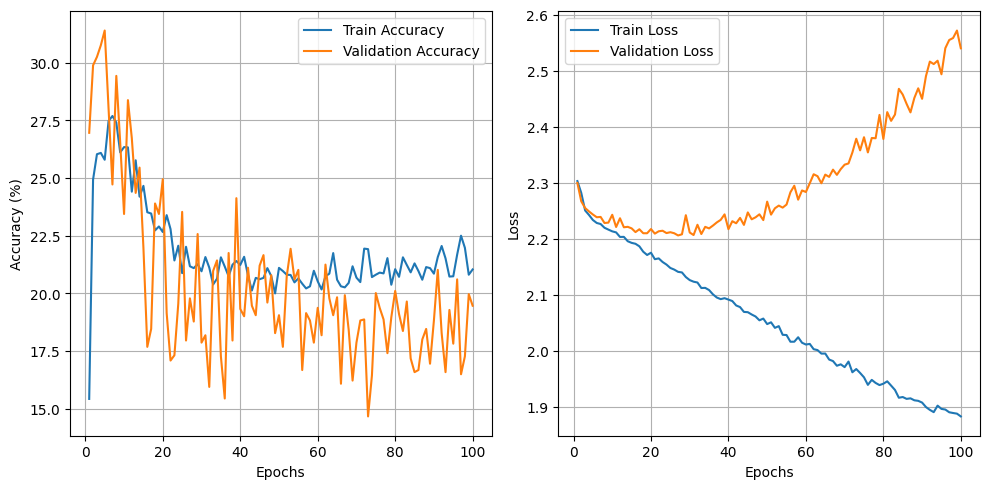

In [8]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), best_epoch_train_acc, label="Train Accuracy")
plt.plot(range(1, num_epochs + 1), best_epoch_val_acc, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), best_epoch_train_loss, label="Train Loss")
plt.plot(range(1, num_epochs + 1), best_epoch_val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.tight_layout()
plt.savefig(f'./Graficas_entrenamiento/v5/representacion_1/longitud_8/CNN1D.png')
plt.show()

***Cargar el modelo :***

In [9]:
model.load_state_dict(torch.load("./Modelos/v5/representacion_1/longitud_8/CNN1D_fold_2.pth"))
model.to(device)
model.eval()

CNN1D(
  (conv1): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

***Evaluar el modelo :***

In [10]:
all_preds = []
all_labels = []

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [ ]:
print(train_df['Type'].unique())         # Ver las clases únicas
print(train_df['Type'].value_counts())   # Ver el conteo de cada clase

***Matriz de confusión :***

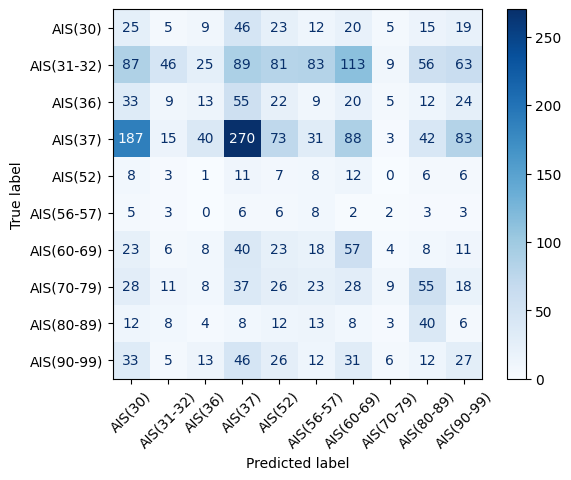

In [11]:
class_names = ['AIS(30)','AIS(31-32)','AIS(36)','AIS(37)','AIS(52)','AIS(56-57)','AIS(60-69)','AIS(70-79)','AIS(80-89)','AIS(90-99)']
#class_names = ['Cargo', 'Fishing', 'Military', 'Sailing', 'Tanker']
#class_names = ['Cargo', 'Container', 'Cruise', 'Fishing', 'Tanker']
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.show()

***Análisis de los resultados obtenidos :***

In [12]:
print(classification_report(all_labels, all_preds, target_names=class_names))

output_dir = Path('./Resultados/v5/representacion_1/longitud_8')

classification_text = classification_report(all_labels, all_preds, target_names=class_names)

with open(output_dir / 'CNN1D_report.txt', 'w') as f:
    f.write(classification_text)

              precision    recall  f1-score   support

     AIS(30)       0.06      0.14      0.08       179
  AIS(31-32)       0.41      0.07      0.12       652
     AIS(36)       0.11      0.06      0.08       202
     AIS(37)       0.44      0.32      0.38       832
     AIS(52)       0.02      0.11      0.04        62
  AIS(56-57)       0.04      0.21      0.06        38
  AIS(60-69)       0.15      0.29      0.20       198
  AIS(70-79)       0.20      0.04      0.06       243
  AIS(80-89)       0.16      0.35      0.22       114
  AIS(90-99)       0.10      0.13      0.11       211

    accuracy                           0.18      2731
   macro avg       0.17      0.17      0.14      2731
weighted avg       0.29      0.18      0.19      2731

